In [ ]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 2.8 MB/s eta 0:00:00


only training

Epoch [100/2000], Loss (CALL): 0.1956
Epoch [200/2000], Loss (CALL): 0.1949
Epoch [300/2000], Loss (CALL): 0.1947
Epoch [400/2000], Loss (CALL): 0.1944
Epoch [500/2000], Loss (CALL): 0.1941
Epoch [600/2000], Loss (CALL): 0.1938
Epoch [700/2000], Loss (CALL): 0.1935
Epoch [800/2000], Loss (CALL): 0.1931
Epoch [900/2000], Loss (CALL): 0.1928
Epoch [1000/2000], Loss (CALL): 0.1924
Epoch [1100/2000], Loss (CALL): 0.1920
Epoch [1200/2000], Loss (CALL): 0.1915
Epoch [1300/2000], Loss (CALL): 0.1910
Epoch [1400/2000], Loss (CALL): 0.1903
Epoch [1500/2000], Loss (CALL): 0.1895
Epoch [1600/2000], Loss (CALL): 0.1884
Epoch [1700/2000], Loss (CALL): 0.1869
Epoch [1800/2000], Loss (CALL): 0.1848
Epoch [1900/2000], Loss (CALL): 0.1815
Epoch [2000/2000], Loss (CALL): 0.1756
Epoch [100/2000], Loss (PUT): 0.1342
Epoch [200/2000], Loss (PUT): 0.1278
Epoch [300/2000], Loss (PUT): 0.1244
Epoch [400/2000], Loss (PUT): 0.1187
Epoch [500/2000], Loss (PUT): 0.1129
Epoch [600/2000], Loss (PUT): 0.1082
Epoch [

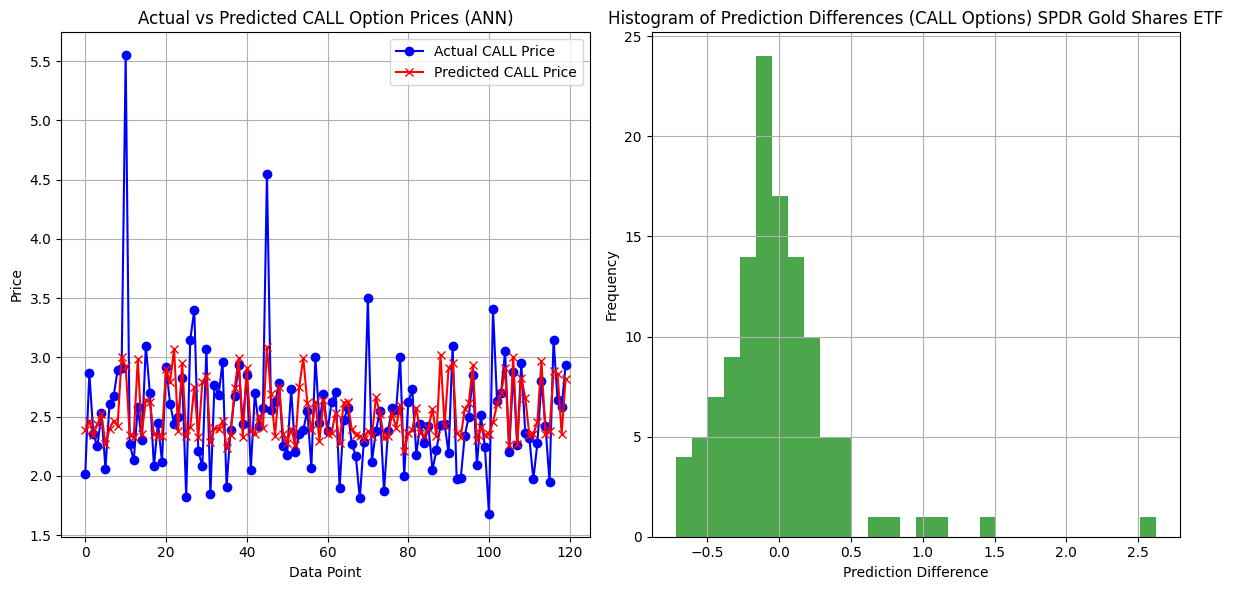

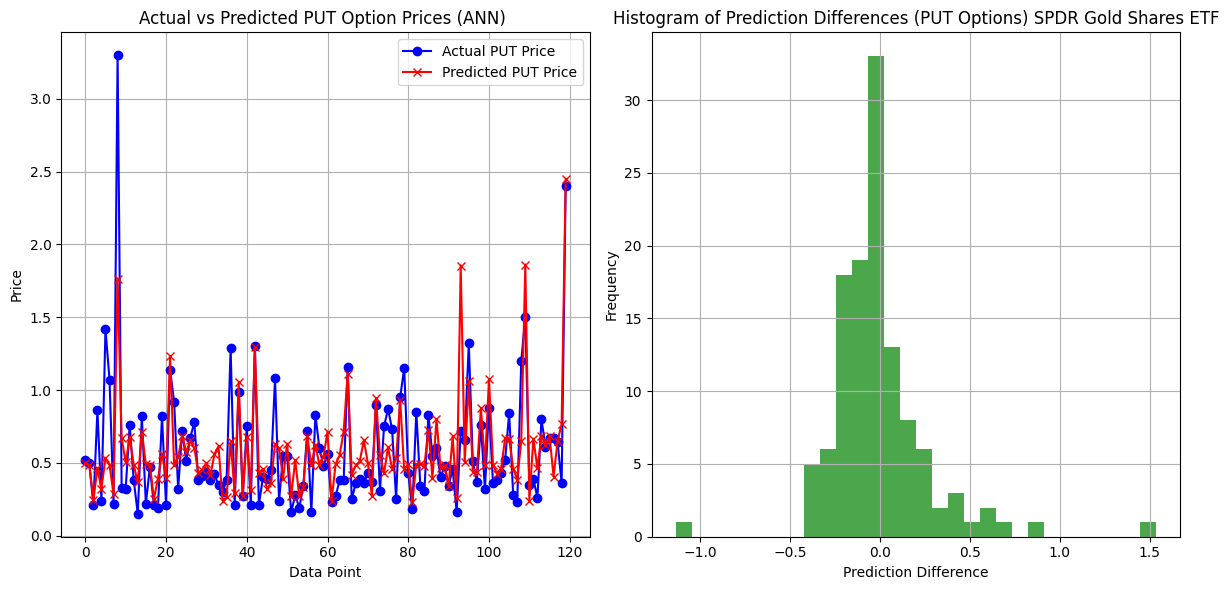

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Data_for_call_options= pd.read_excel('train_data.xlsx', sheet_name='GLD_call')
Data_for_put_options = pd.read_excel('train_data.xlsx', sheet_name='GLD_put')

Features_for_call_options = data_call[['Underlying Price', 'Strike 1']].copy()
Features_for_call_options['Time to Maturity'] = 5 / 365
Data_Target_call = data_call['Close']

Features_for_put_options = Data_for_put_options[['Underlying Price', 'Strike 1']].copy()
Features_for_put_options['Time to Maturity'] = 5 / 365
Data_Target_put = Data_for_put_options['Close']

Features_for_call_options['Underlying Price'] = pd.to_numeric(Features_for_call_options['Underlying Price'], errors='coerce')
Features_for_put_options['Underlying Price'] = pd.to_numeric(Features_for_put_options['Underlying Price'], errors='coerce')

Features_for_call_options = Features_for_call_options.dropna(subset=['Underlying Price'])
Features_for_put_options = Features_for_put_options.dropna(subset=['Underlying Price'])

scaler_for_call_options = MinMaxScaler()
ScaledFeatures_for_call_options = scaler_for_call_options.fit_transform(Features_for_call_options)

scaler_for_put_options = MinMaxScaler()
ScaledFeatures_for_put_options = scaler_for_put_options.fit_transform(Features_for_put_options)

class OptionPricingNN(nn.Module):
    def __init__(self, Input_Param, Output_param):
        super(OptionPricingNN, self).__init__()
        self.L1 = nn.Linear(Input_Param, 150)
        self.RELU_1 = nn.ReLU()
        self.L2 = nn.Linear(150, 100)
        self.RELU_2 = nn.ReLU()
        self.L3 = nn.Linear(100, 80)
        self.RELU_3 = nn.ReLU()
        self.L4 = nn.Linear(80, 60)
        self.RELU_4 = nn.ReLU()
        self.L5 = nn.Linear(60, 40)
        self.RELU_5 = nn.ReLU()
        self.L6 = nn.Linear(40, 20)
        self.RELU_6 = nn.ReLU()
        self.L7 = nn.Linear(20, Output_param)

    def forward(self, x):
        x = self.L1(x)
        x = self.RELU_1(x)
        x = self.L2(x)
        x = self.RELU_2(x)
        x = self.L3(x)
        x = self.RELU_3(x)
        x = self.L4(x)
        x = self.RELU_4(x)
        x = self.L5(x)
        x = self.RELU_5(x)
        x = self.L6(x)
        x = self.RELU_6(x)
        x = self.L7(x)
        return x

Input_Param_call = ScaledFeatures_for_call_options.shape[1]
Output_param = 1
Model_Call_options = OptionPricingNN(Input_Param_call, Output_param)

Input_Param_put = ScaledFeatures_for_put_options.shape[1]
Model_for_put_options = OptionPricingNN(Input_Param_put, Output_param)

call_options_Criteria = nn.MSELoss()
Optimizer_for_calls = optim.Adam(Model_Call_options.parameters(), lr=0.001)

Put_options_Criteria = nn.MSELoss()
optimizer_put = optim.Adam(Model_for_put_options.parameters(), lr=0.001)

Num_Epochs = 2000
for Epoch in range(Num_Epochs):
    Optimizer_for_calls.zero_grad()
    Target_out_call = Model_Call_options(torch.tensor(ScaledFeatures_for_call_options, dtype=torch.float32))
    Loss_for_call_options = call_options_Criteria(Target_out_call, torch.tensor(Data_Target_call.values, dtype=torch.float32).view(-1, 1))
    Loss_for_call_options.backward()
    Optimizer_for_calls.step()
    if (Epoch + 1) % 100 == 0:
        print(f'Epoch [{Epoch+1}/{Num_Epochs}], Loss (CALL): {Loss_for_call_options.item():.4f}')

for Epoch in range(Num_Epochs):
    optimizer_put.zero_grad()
    Target_out_put = Model_for_put_options(torch.tensor(ScaledFeatures_for_put_options, dtype=torch.float32))
    Loss_for_put_options = Put_options_Criteria(Target_out_put, torch.tensor(Data_Target_put.values, dtype=torch.float32).view(-1, 1))
    Loss_for_put_options.backward()
    optimizer_put.step()
    if (Epoch + 1) % 100 == 0:
        print(f'Epoch [{Epoch+1}/{Num_Epochs}], Loss (PUT): {Loss_for_put_options.item():.4f}')

with torch.no_grad():
    Model_Call_options.eval()
    train_predictions_call = Model_Call_options(torch.tensor(ScaledFeatures_for_call_options, dtype=torch.float32)).numpy().flatten()

with torch.no_grad():
    Model_for_put_options.eval()
    train_predictions_put = Model_for_put_options(torch.tensor(ScaledFeatures_for_put_options, dtype=torch.float32)).numpy().flatten()

def Metrics(actual, predicted):
    MSE = np.mean((actual - predicted) ** 2)
    MAE = np.mean(np.abs(actual - predicted))
    MAPE = np.mean(np.abs((actual - predicted) / actual)) * 100
    return MSE, MAE, MAPE

MSE_call, MAE_call, MAPE_call = Metrics(Data_Target_call, train_predictions_call)
print(f'CALL Options - MSE (Training): {MSE_call:.4f}, MAE (Training): {MAE_call:.4f}, MAPE (Training): {MAPE_call:.4f}%')

MSE_put, MAE_put, MAPE_put = Metrics(Data_Target_put, train_predictions_put)
print(f'PUT Options - MSE (Training): {MSE_put:.4f}, MAE (Training): {MAE_put:.4f}, MAPE (Training): {MAPE_put:.4f}%')

Res_Call_options = pd.DataFrame({'Underlying Price': ScaledFeatures_for_call_options[:, 0],
                             'Strike 1': ScaledFeatures_for_call_options[:, 1],
                             'Actual Close price': Data_Target_call,
                             'Predicted Price': train_predictions_call})

Res_Call_options['Prediction Difference'] = Res_Call_options['Actual Close price'] - Res_Call_options['Predicted Price']
Res_Call_options['Average Prediction Difference'] = Res_Call_options['Prediction Difference'].mean()

Res_Call_options['MSE'] = MSE_call
Res_Call_options['MAE'] = MAE_call
Res_Call_options['MAPE'] = MAPE_call

print("Call Options Results:")
print(Res_Call_options)

Res_Put_options = pd.DataFrame({'Underlying Price': ScaledFeatures_for_put_options[:, 0],
                            'Strike 1': ScaledFeatures_for_put_options[:, 1],
                            'Actual Close price': Data_Target_put,
                            'Predicted Price': train_predictions_put})

Res_Put_options['Prediction Difference'] = Res_Put_options['Actual Close price'] - Res_Put_options['Predicted Price']
Res_Put_options['Average Prediction Difference'] = Res_Put_options['Prediction Difference'].mean()

Res_Put_options['MSE'] = MSE_put
Res_Put_options['MAE'] = MAE_put
Res_Put_options['MAPE'] = MAPE_put

print("Put Options Results:")
print(Res_Put_options)

with pd.ExcelWriter('GLD_Historical_with_ANN_only_Training.xlsx') as writer:
    Res_Call_options.to_excel(writer, sheet_name='Call_Options', index=False)
    Res_Put_options.to_excel(writer, sheet_name='Put_Options', index=False)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(Data_Target_call)), Data_Target_call, label='Actual CALL Price', color='blue', marker='o')
plt.plot(range(len(Res_Call_options['Predicted Price'])), Res_Call_options['Predicted Price'], label='Predicted CALL Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted CALL Option Prices (ANN)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(Res_Call_options['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (CALL Options) SPDR Gold Shares ETF')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(Data_Target_put)), Data_Target_put, label='Actual PUT Price', color='blue', marker='o')
plt.plot(range(len(Res_Put_options['Predicted Price'])), Res_Put_options['Predicted Price'], label='Predicted PUT Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted PUT Option Prices (ANN) SPDR Gold Shares ETF')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(Res_Put_options['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (PUT Options) SPDR Gold Shares ETF')
plt.grid(True)

plt.tight_layout()
plt.show()




testing


CALL Options - MSE (Testing): 0.2739, MAE (Testing): 0.3173, MAPE (Testing): 11.1394%
PUT Options - MSE (Testing): 0.1070, MAE (Testing): 0.1963, MAPE (Testing): 38.6311%
Call Options Testing Results:
Average Prediction Difference: 0     0.079346
1     0.079346
2     0.079346
3     0.079346
4     0.079346
5     0.079346
6     0.079346
7     0.079346
8     0.079346
9     0.079346
10    0.079346
11    0.079346
12    0.079346
13    0.079346
14    0.079346
15    0.079346
16    0.079346
17    0.079346
18    0.079346
19    0.079346
20    0.079346
21    0.079346
22    0.079346
23    0.079346
24    0.079346
25    0.079346
26    0.079346
27    0.079346
28    0.079346
29    0.079346
30    0.079346
31    0.079346
32    0.079346
33    0.079346
34    0.079346
35    0.079346
36    0.079346
37    0.079346
38    0.079346
39    0.079346
40    0.079346
41    0.079346
42    0.079346
43    0.079346
44    0.079346
45    0.079346
46    0.079346
47    0.079346
48    0.079346
49    0.079346
Name: Average Pred

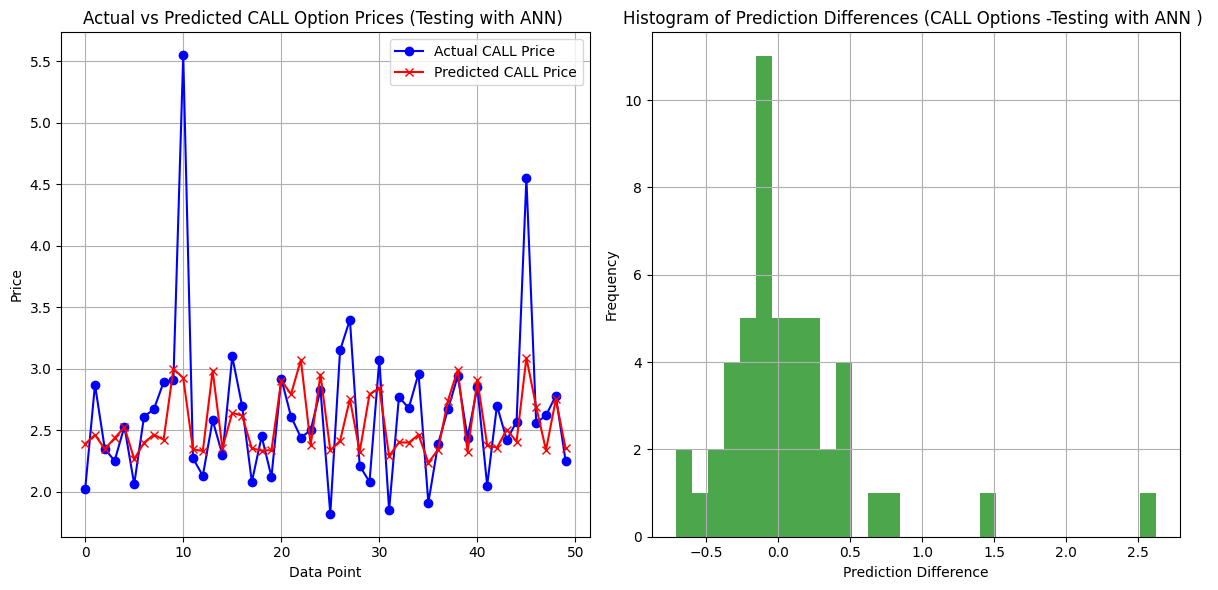

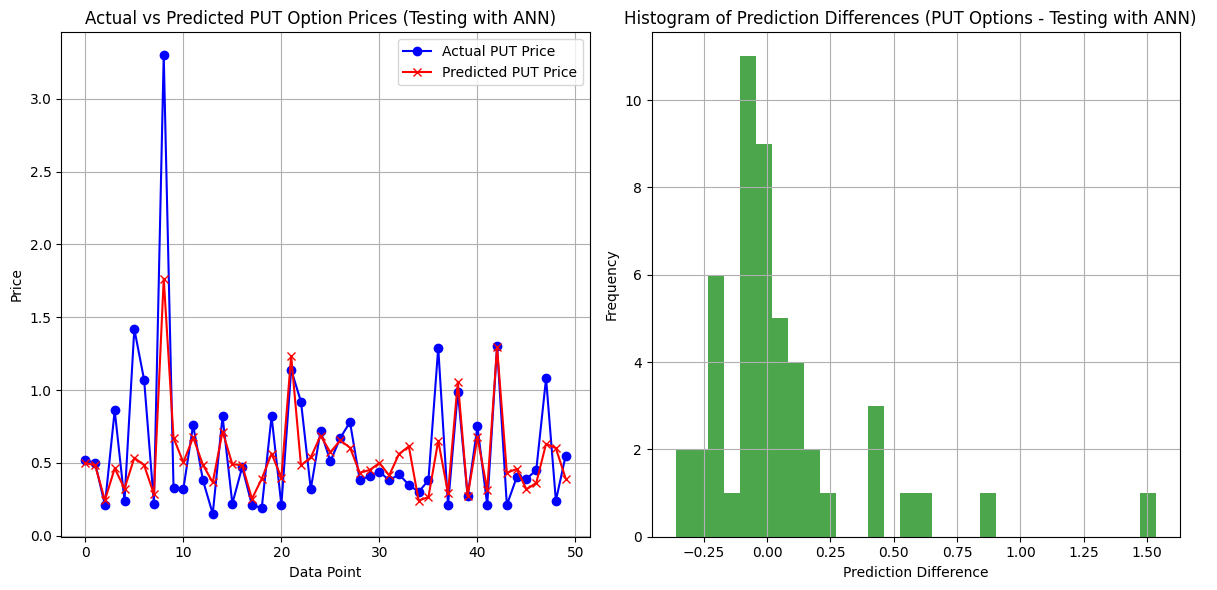

In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

testing_Data_for_call_options= pd.read_excel('test_data.xlsx', sheet_name='GLD_call')
testing_Data_for_put_options = pd.read_excel('test_data.xlsx', sheet_name='GLD_put')

testing_Features_for_call_options = testing_data_call[['Underlying Price', 'Strike 1']].copy()
testing_Features_for_call_options['Time to Maturity'] = 5 / 365
testing_Data_Target_call = testing_data_call['Close']

testing_Features_for_put_options = testing_Data_for_put_options[['Underlying Price', 'Strike 1']].copy()
testing_Features_for_put_options['Time to Maturity'] = 5 / 365
testing_Data_Target_put = testing_Data_for_put_options['Close']

testing_scaledFeatures_for_call_options = scaler_for_call_options.transform(testing_Features_for_call_options)
testing_scaledFeatures_for_put_options = scaler_for_put_options.transform(testing_Features_for_put_options)

with torch.no_grad():
    Model_Call_options.eval()
    test_predictions_call = Model_Call_options(torch.tensor(testing_scaledFeatures_for_call_options, dtype=torch.float32)).numpy().flatten()

with torch.no_grad():
    Model_for_put_options.eval()
    test_predictions_put = Model_for_put_options(torch.tensor(testing_scaledFeatures_for_put_options, dtype=torch.float32)).numpy().flatten()

MSE_call_test, MAE_call_test, MAPE_call_test = Metrics(testing_Data_Target_call, test_predictions_call)
print(f'CALL Options - MSE (Testing): {MSE_call_test:.4f}, MAE (Testing): {MAE_call_test:.4f}, MAPE (Testing): {MAPE_call_test:.4f}%')

MSE_put_test, MAE_put_test, MAPE_put_test = Metrics(testing_Data_Target_put, test_predictions_put)
print(f'PUT Options - MSE (Testing): {MSE_put_test:.4f}, MAE (Testing): {MAE_put_test:.4f}, MAPE (Testing): {MAPE_put_test:.4f}%')

call_testing_results = pd.DataFrame({'Underlying Price': testing_scaledFeatures_for_call_options[:, 0],
                                     'Strike 1': testing_scaledFeatures_for_call_options[:, 1],
                                     'Actual Close price': testing_Data_Target_call,
                                     'Predicted Price': test_predictions_call})

put_testing_results = pd.DataFrame({'Underlying Price': testing_scaledFeatures_for_put_options[:, 0],
                                    'Strike 1': testing_scaledFeatures_for_put_options[:, 1],
                                    'Actual Close price': testing_Data_Target_put,
                                    'Predicted Price': test_predictions_put})

call_testing_results['Prediction Difference'] = call_testing_results['Actual Close price'] - call_testing_results['Predicted Price']
put_testing_results['Prediction Difference'] = put_testing_results['Actual Close price'] - put_testing_results['Predicted Price']

call_testing_results['Average Prediction Difference'] = call_testing_results['Prediction Difference'].mean()
put_testing_results['Average Prediction Difference'] = put_testing_results['Prediction Difference'].mean()

print("Call Options Testing Results:")
print("Average Prediction Difference:", call_testing_results['Average Prediction Difference'])
print("Individual Prediction Differences:")
print(call_testing_results['Prediction Difference'])

print("\nPut Options Testing Results:")
print("Average Prediction Difference:", put_testing_results['Average Prediction Difference'])
print("Individual Prediction Differences:")
print(put_testing_results['Prediction Difference'])



average_prediction_difference_call = call_testing_results['Prediction Difference'].mean()
average_prediction_difference_put = put_testing_results['Prediction Difference'].mean()

print("Average Prediction Difference for Call Options (Testing):", average_prediction_difference_call)
print("Average Prediction Difference for Put Options (Testing):", average_prediction_difference_put)

call_testing_results['MSE'] = MSE_call_test
call_testing_results['MAE'] = MAE_call_test
call_testing_results['MAPE'] = MAPE_call_test

put_testing_results['MSE'] = MSE_put_test
put_testing_results['MAE'] = MAE_put_test
put_testing_results['MAPE'] = MAPE_put_test

print("Call Options Testing Results:")
print(call_testing_results)

print("Put Options Testing Results:")
print(put_testing_results)


with pd.ExcelWriter('GLD_testing_results_with_ANN.xlsx') as writer:
    call_testing_results.to_excel(writer, sheet_name='Call_Options', index=False)

    put_testing_results.to_excel(writer, sheet_name='Put_Options', index=False)


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(range(len(testing_Data_Target_call)), testing_Data_Target_call, label='Actual CALL Price', color='blue', marker='o')
plt.plot(range(len(call_testing_results['Predicted Price'])), call_testing_results['Predicted Price'], label='Predicted CALL Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted CALL Option Prices (Testing with ANN) ')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.hist(call_testing_results['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (CALL Options -Testing with ANN ) ')
plt.grid(True)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(range(len(testing_Data_Target_put)), testing_Data_Target_put, label='Actual PUT Price', color='blue', marker='o')
plt.plot(range(len(put_testing_results['Predicted Price'])), put_testing_results['Predicted Price'], label='Predicted PUT Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted PUT Option Prices (Testing with ANN)  ')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(put_testing_results['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (PUT Options - Testing with ANN)  ')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd


file_path = 'testing.xlsx'


worksheets_to_clean = ['GLD_put', 'GLD_call']


with pd.ExcelWriter('cleaned_data.xlsx') as writer_cleaned:
    for sheet_name in worksheets_to_clean:

        df = pd.read_excel(file_path, sheet_name=sheet_name)


        missing_values = df.isnull().sum()


        df_cleaned = df.dropna()


        invalid_values = ['#N/A', 'Invalid Security']
        for invalid_value in invalid_values:
            df_cleaned = df_cleaned[~df_cleaned.apply(lambda row: row.astype(str).str.contains(invalid_value).any(), axis=1)]


        df_cleaned.to_excel(writer_cleaned, sheet_name=sheet_name, index=False)

print("Cleaned data saved to cleaned_data.xlsx")




Cleaned data saved to cleaned_data.xlsx


In [ ]:
import pandas as pd
import numpy as np


train_random_seed = 279
test_random_seed = 279


np.random.seed(train_random_seed)


file_path = 'cleaned_data.xlsx'


worksheets_to_use = ['GLD_put', 'GLD_call']

train_data = {ws: pd.DataFrame() for ws in worksheets_to_use}
test_data = {ws: pd.DataFrame() for ws in worksheets_to_use}

for sheet_name in worksheets_to_use:
    df = pd.read_excel(file_path, sheet_name=sheet_name)

    total_rows = df.shape[0]


    np.random.seed(test_random_seed)


    train_indices = np.random.choice(total_rows, size=120, replace=False)


    np.random.seed(train_random_seed)


    test_indices = np.random.choice(total_rows, size=50, replace=False)


    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]


    train_data[sheet_name] = train_df
    test_data[sheet_name] = test_df


with pd.ExcelWriter('train_data.xlsx') as train_writer:
    for ws, data in train_data.items():
        data.to_excel(train_writer, sheet_name=ws, index=False)


with pd.ExcelWriter('test_data.xlsx') as test_writer:
    for ws, data in test_data.items():
        data.to_excel(test_writer, sheet_name=ws, index=False)

print("Training data saved to train_data.xlsx")
print("Testing data saved to test_data.xlsx")



Training data saved to train_data.xlsx
Testing data saved to test_data.xlsx


grid search

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import itertools


Data_for_call_options= pd.read_excel('train_data.xlsx', sheet_name='GLD_call')
Data_for_put_options = pd.read_excel('train_data.xlsx', sheet_name='GLD_put')


Features_for_call_options = data_call[['Underlying Price', 'Strike 1']].copy()
Features_for_call_options['Time to Maturity'] = 5 / 365
Data_Target_call = data_call['Close']

Features_for_put_options = Data_for_put_options[['Underlying Price', 'Strike 1']].copy()
Features_for_put_options['Time to Maturity'] = 5 / 365
Data_Target_put = Data_for_put_options['Close']

Features_for_call_options['Underlying Price'] = pd.to_numeric(Features_for_call_options['Underlying Price'], errors='coerce')
Features_for_put_options['Underlying Price'] = pd.to_numeric(Features_for_put_options['Underlying Price'], errors='coerce')

Features_for_call_options = Features_for_call_options.dropna(subset=['Underlying Price'])
Features_for_put_options = Features_for_put_options.dropna(subset=['Underlying Price'])


scaler_for_call_options = MinMaxScaler()
ScaledFeatures_for_call_options = scaler_for_call_options.fit_transform(Features_for_call_options)

scaler_for_put_options = MinMaxScaler()
ScaledFeatures_for_put_options = scaler_for_put_options.fit_transform(Features_for_put_options)


class OptionPricingNN(nn.Module):
    def __init__(self, Input_Param, Output_param, Neurons):
        super(OptionPricingNN, self).__init__()
        self.L1 = nn.Linear(Input_Param, Neurons[0])
        self.RELU_1 = nn.ReLU()
        self.L2 = nn.Linear(Neurons[0], Neurons[1])
        self.RELU_2 = nn.ReLU()
        self.L3 = nn.Linear(Neurons[1], Neurons[2])
        self.RELU_3 = nn.ReLU()
        self.L4 = nn.Linear(Neurons[2], Neurons[3])
        self.RELU_4 = nn.ReLU()
        self.L5 = nn.Linear(Neurons[3], Neurons[4])
        self.RELU_5 = nn.ReLU()
        self.L6 = nn.Linear(Neurons[4], Neurons[5])
        self.RELU_6 = nn.ReLU()
        self.L7 = nn.Linear(Neurons[5], Output_param)

    def forward(self, x):
        x = self.L1(x)
        x = self.RELU_1(x)
        x = self.L2(x)
        x = self.RELU_2(x)
        x = self.L3(x)
        x = self.RELU_3(x)
        x = self.L4(x)
        x = self.RELU_4(x)
        x = self.L5(x)
        x = self.RELU_5(x)
        x = self.L6(x)
        x = self.RELU_6(x)
        x = self.L7(x)
        return x


def Metrics(actual, predicted):
    MSE = np.mean((actual - predicted) ** 2)
    MAE = np.mean(np.abs(actual - predicted))
    MAPE = np.mean(np.abs((actual - predicted) / actual)) * 100
    return MSE, MAE, MAPE


Learning_Rates = [0.001, 0.01, 0.1]
Num_neurons = [[50, 100, 150, 100, 50, 30], [100, 150, 200, 150, 100, 50], [150, 200, 250, 200, 150, 100]]

best_Loss_for_call_options = float('inf')
Best_Learning_rate_call = None
best_Neurons_call = None

best_Loss_for_put_options = float('inf')
Best_Learning_rate_put = None
best_Neurons_put = None


for lr, Neurons in itertools.product(Learning_Rates, Num_neurons):

    Input_Param_call = ScaledFeatures_for_call_options.shape[1]
    Output_param = 1
    Model_Call_options = OptionPricingNN(Input_Param_call, Output_param, Neurons)


    Optimizer_for_calls = optim.Adam(Model_Call_options.parameters(), lr=lr)


    call_options_Criteria = nn.MSELoss()


    Num_Epochs = 2000
    for Epoch in range(Num_Epochs):
        Optimizer_for_calls.zero_grad()
        Target_out_call = Model_Call_options(torch.tensor(ScaledFeatures_for_call_options, dtype=torch.float32))
        Loss_for_call_options = call_options_Criteria(Target_out_call, torch.tensor(Data_Target_call.values, dtype=torch.float32).view(-1, 1))
        Loss_for_call_options.backward()
        Optimizer_for_calls.step()


    with torch.no_grad():
        Model_Call_options.eval()
        train_predictions_call = Model_Call_options(torch.tensor(ScaledFeatures_for_call_options, dtype=torch.float32)).numpy().flatten()

    MSE_call, _, _ = Metrics(Data_Target_call, train_predictions_call)


    if MSE_call < best_Loss_for_call_options:
        best_Loss_for_call_options = MSE_call
        Best_Learning_rate_call = lr
        best_Neurons_call = Neurons


for lr, Neurons in itertools.product(Learning_Rates, Num_neurons):

    Input_Param_put = ScaledFeatures_for_put_options.shape[1]
    Model_for_put_options = OptionPricingNN(Input_Param_put, Output_param, Neurons)

    optimizer_put = optim.Adam(Model_for_put_options.parameters(), lr=lr)

    Put_options_Criteria = nn.MSELoss()


    Num_Epochs = 2000
    for Epoch in range(Num_Epochs):
        optimizer_put.zero_grad()
        Target_out_put = Model_for_put_options(torch.tensor(ScaledFeatures_for_put_options, dtype=torch.float32))
        Loss_for_put_options = Put_options_Criteria(Target_out_put, torch.tensor(Data_Target_put.values, dtype=torch.float32).view(-1, 1))
        Loss_for_put_options.backward()
        optimizer_put.step()


    with torch.no_grad():
        Model_for_put_options.eval()
        train_predictions_put = Model_for_put_options(torch.tensor(ScaledFeatures_for_put_options, dtype=torch.float32)).numpy().flatten()

    MSE_put, _, _ = Metrics(Data_Target_put, train_predictions_put)


    if MSE_put < best_Loss_for_put_options:
        best_Loss_for_put_options = MSE_put
        Best_Learning_rate_put = lr
        best_Neurons_put = Neurons

print("Best parameters for CALL options:")
print(f'Learning rate: {Best_Learning_rate_call}, Neurons: {best_Neurons_call}, MSE: {best_Loss_for_call_options:.4f}')

print("\nBest parameters for PUT options:")
print(f'Learning rate: {Best_Learning_rate_put}, Neurons: {best_Neurons_put}, MSE: {best_Loss_for_put_options:.4f}')


Input_Param_call = ScaledFeatures_for_call_options.shape[1]
Model_Call_options = OptionPricingNN(Input_Param_call, Output_param, best_Neurons_call)
Optimizer_for_calls = optim.Adam(Model_Call_options.parameters(), lr=Best_Learning_rate_call)
call_options_Criteria = nn.MSELoss()


Num_Epochs = 2000
for Epoch in range(Num_Epochs):
    Optimizer_for_calls.zero_grad()
    Target_out_call = Model_Call_options(torch.tensor(ScaledFeatures_for_call_options, dtype=torch.float32))
    Loss_for_call_options = call_options_Criteria(Target_out_call, torch.tensor(Data_Target_call.values, dtype=torch.float32).view(-1, 1))
    Loss_for_call_options.backward()
    Optimizer_for_calls.step()

with torch.no_grad():
    Model_Call_options.eval()
    train_predictions_call = Model_Call_options(torch.tensor(ScaledFeatures_for_call_options, dtype=torch.float32)).numpy().flatten()

MSE_call, MAE_call, MAPE_call = Metrics(Data_Target_call, train_predictions_call)
print("Evaluation metrics for CALL options:")
print(f'MSE: {MSE_call:.4f}, MAE: {MAE_call:.4f}, MAPE: {MAPE_call:.4f}%')


Input_Param_put = ScaledFeatures_for_put_options.shape[1]
Model_for_put_options = OptionPricingNN(Input_Param_put, Output_param, best_Neurons_put)
optimizer_put = optim.Adam(Model_for_put_options.parameters(), lr=Best_Learning_rate_put)
Put_options_Criteria = nn.MSELoss()


for Epoch in range(Num_Epochs):
    optimizer_put.zero_grad()
    Target_out_put = Model_for_put_options(torch.tensor(ScaledFeatures_for_put_options, dtype=torch.float32))
    Loss_for_put_options = Put_options_Criteria(Target_out_put, torch.tensor(Data_Target_put.values, dtype=torch.float32).view(-1, 1))
    Loss_for_put_options.backward()
    optimizer_put.step()


with torch.no_grad():
    Model_for_put_options.eval()
    train_predictions_put = Model_for_put_options(torch.tensor(ScaledFeatures_for_put_options, dtype=torch.float32)).numpy().flatten()

MSE_put, MAE_put, MAPE_put = Metrics(Data_Target_put, train_predictions_put)
print("\nEvaluation metrics for PUT options:")
print(f'MSE: {MSE_put:.4f}, MAE: {MAE_put:.4f}, MAPE: {MAPE_put:.4f}%')



Res_Call_options = pd.DataFrame({'Underlying Price': ScaledFeatures_for_call_options[:, 0],
                             'Strike 1': ScaledFeatures_for_call_options[:, 1],
                             'Actual Close price': Data_Target_call,
                             'Predicted Price': train_predictions_call})


Res_Call_options['Prediction Difference'] = Res_Call_options['Actual Close price'] - Res_Call_options['Predicted Price']
Res_Call_options['Average Prediction Difference (ANN with Grid Search)'] = Res_Call_options['Prediction Difference'].mean()


Res_Call_options['MSE'] = MSE_call
Res_Call_options['MAE'] = MAE_call
Res_Call_options['MAPE'] = MAPE_call


print("Call Options Results:")
print(Res_Call_options)

Res_Put_options = pd.DataFrame({'Underlying Price': ScaledFeatures_for_put_options[:, 0],
                            'Strike 1': ScaledFeatures_for_put_options[:, 1],
                            'Actual Close price': Data_Target_put,
                            'Predicted Price': train_predictions_put})


Res_Put_options['Prediction Difference'] = Res_Put_options['Actual Close price'] - Res_Put_options['Predicted Price']
Res_Put_options['Average Prediction Difference'] = Res_Put_options['Prediction Difference'].mean()


Res_Put_options['MSE'] = MSE_put
Res_Put_options['MAE'] = MAE_put
Res_Put_options['MAPE'] = MAPE_put


print("\nPut Options Results:")
print(Res_Put_options)


with pd.ExcelWriter('training_with-grid-search.xlsx') as writer:
    Res_Call_options.to_excel(writer, sheet_name='Call_Options', index=False)
    Res_Put_options.to_excel(writer, sheet_name='Put_Options', index=False)

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(range(len(Data_Target_call)), Data_Target_call, label='Actual CALL Price', color='blue', marker='o')
plt.plot(range(len(Res_Call_options['Predicted Price'])), Res_Call_options['Predicted Price'], label='Predicted CALL Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted CALL Option Prices (ANN) (ANN with Grid Search)')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.hist(Res_Call_options['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (CALL Options) (ANN with Grid Search)')
plt.grid(True)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(range(len(Data_Target_put)), Data_Target_put, label='Actual PUT Price', color='blue', marker='o')
plt.plot(range(len(Res_Put_options['Predicted Price'])), Res_Put_options['Predicted Price'], label='Predicted PUT Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted PUT Option Prices (ANN with Grid Search) ')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.hist(Res_Put_options['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (PUT Options) (ANN with Grid Search)')
plt.grid(True)

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

Adaboost + ANN

Epoch [100/2000], Loss (CALL): 0.1980
Epoch [200/2000], Loss (CALL): 0.1955
Epoch [300/2000], Loss (CALL): 0.1950
Epoch [400/2000], Loss (CALL): 0.1948
Epoch [500/2000], Loss (CALL): 0.1946
Epoch [600/2000], Loss (CALL): 0.1943
Epoch [700/2000], Loss (CALL): 0.1941
Epoch [800/2000], Loss (CALL): 0.1938
Epoch [900/2000], Loss (CALL): 0.1933
Epoch [1000/2000], Loss (CALL): 0.1928
Epoch [1100/2000], Loss (CALL): 0.1922
Epoch [1200/2000], Loss (CALL): 0.1917
Epoch [1300/2000], Loss (CALL): 0.1911
Epoch [1400/2000], Loss (CALL): 0.1906
Epoch [1500/2000], Loss (CALL): 0.1901
Epoch [1600/2000], Loss (CALL): 0.1895
Epoch [1700/2000], Loss (CALL): 0.1890
Epoch [1800/2000], Loss (CALL): 0.1884
Epoch [1900/2000], Loss (CALL): 0.1877
Epoch [2000/2000], Loss (CALL): 0.1868
Epoch [100/2000], Loss (PUT): 0.1363
Epoch [200/2000], Loss (PUT): 0.1340
Epoch [300/2000], Loss (PUT): 0.1320
Epoch [400/2000], Loss (PUT): 0.1297
Epoch [500/2000], Loss (PUT): 0.1286
Epoch [600/2000], Loss (PUT): 0.1284
Epoch [

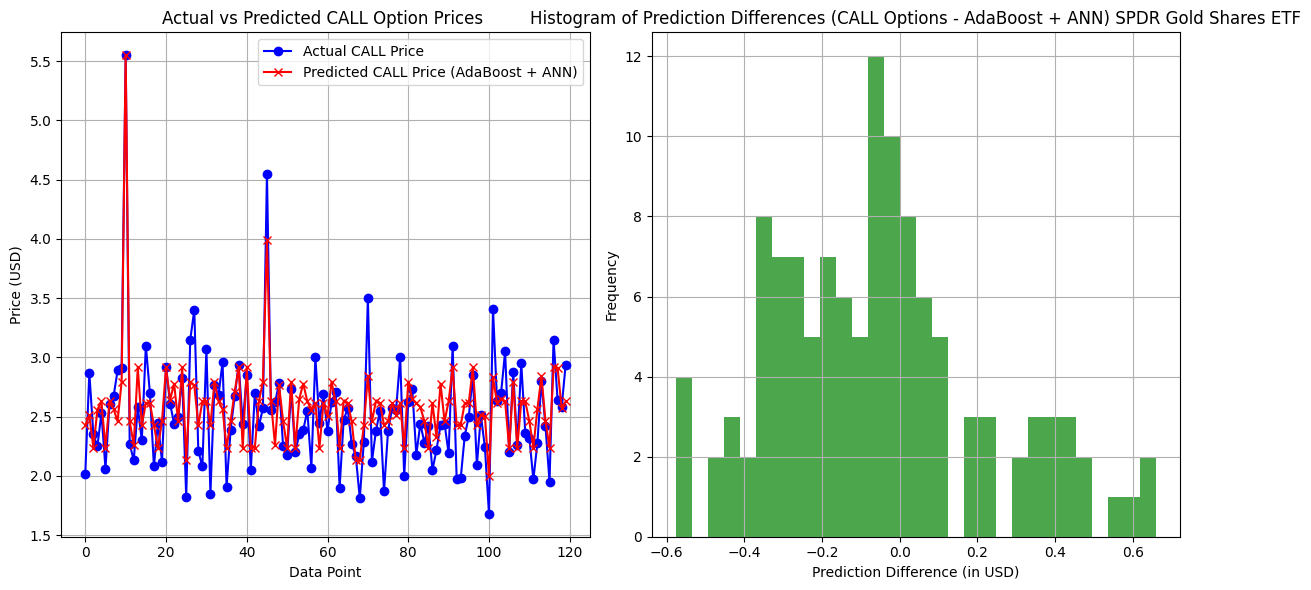

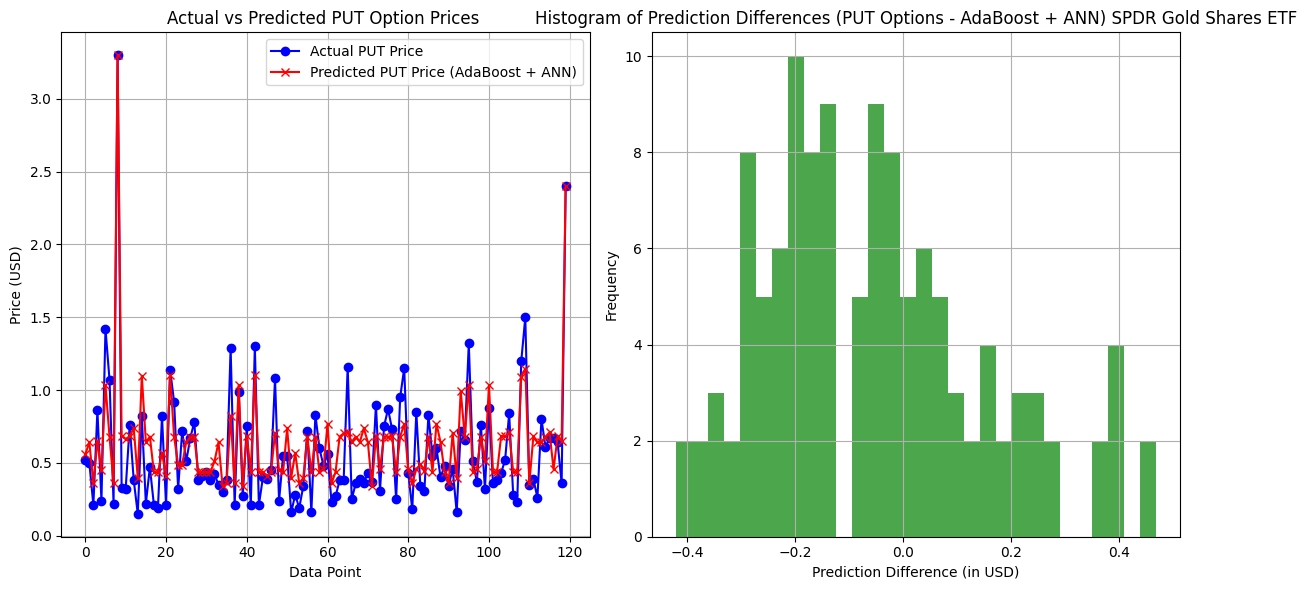

Call Options Results:
     Actual Price  Predicted Price (ANN)  Predicted Price (AdaBoost + ANN)  \
0            2.02               2.380160                          2.428125   
1            2.87               2.363755                          2.511667   
2            2.35               2.339073                          2.238788   
3            2.25               2.367966                          2.558667   
4            2.53               2.513983                          2.628095   
..            ...                    ...                               ...   
115          1.95               2.355983                          2.238788   
116          3.15               2.995267                          2.916429   
117          2.64               3.009834                          2.909000   
118          2.58               2.420029                          2.575085   
119          2.94               2.816530                          2.628095   

     Prediction Difference  Average Predi

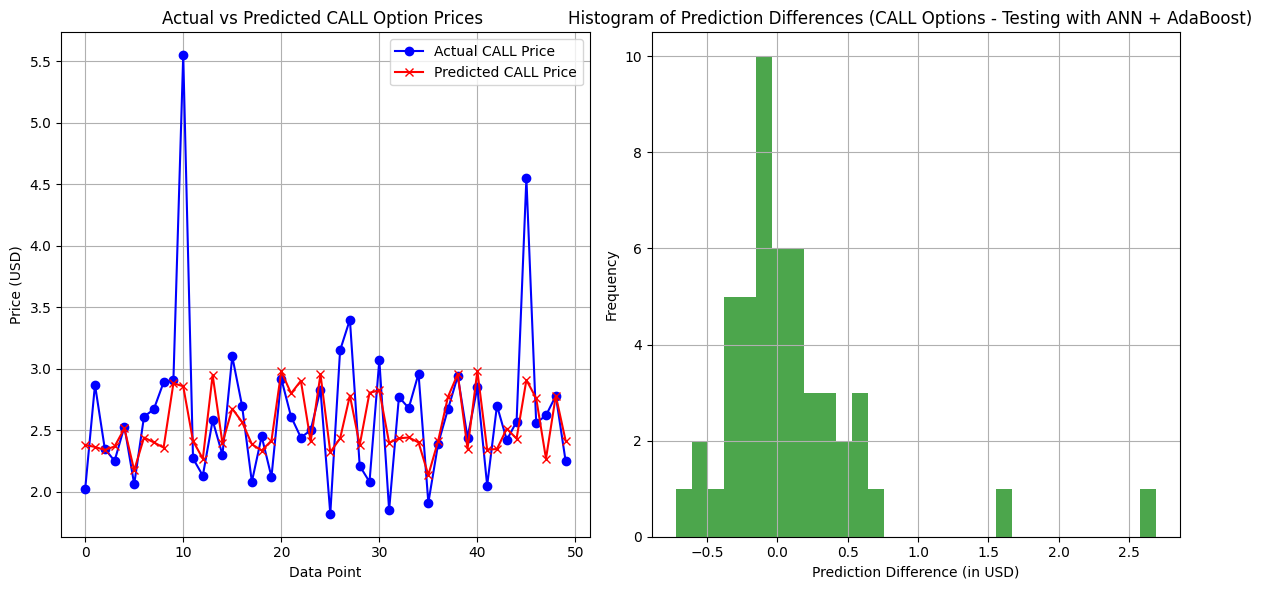

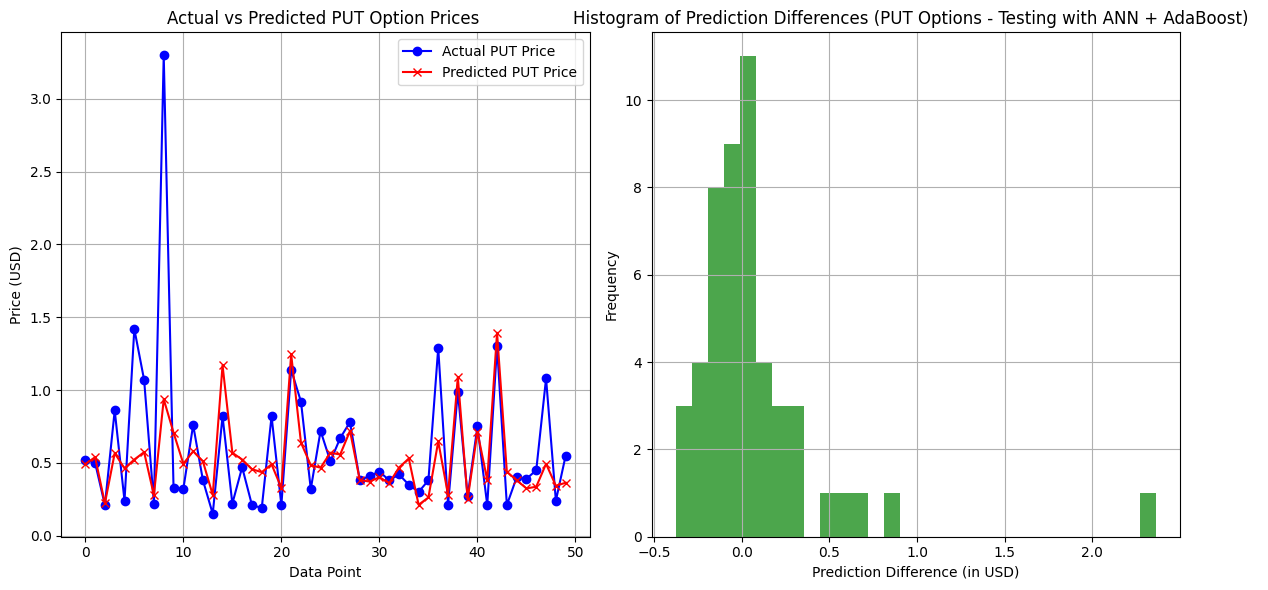

Call Options Testing Results:
Average Prediction Difference: 0     0.086325
1     0.086325
2     0.086325
3     0.086325
4     0.086325
5     0.086325
6     0.086325
7     0.086325
8     0.086325
9     0.086325
10    0.086325
11    0.086325
12    0.086325
13    0.086325
14    0.086325
15    0.086325
16    0.086325
17    0.086325
18    0.086325
19    0.086325
20    0.086325
21    0.086325
22    0.086325
23    0.086325
24    0.086325
25    0.086325
26    0.086325
27    0.086325
28    0.086325
29    0.086325
30    0.086325
31    0.086325
32    0.086325
33    0.086325
34    0.086325
35    0.086325
36    0.086325
37    0.086325
38    0.086325
39    0.086325
40    0.086325
41    0.086325
42    0.086325
43    0.086325
44    0.086325
45    0.086325
46    0.086325
47    0.086325
48    0.086325
49    0.086325
Name: Average Prediction Difference, dtype: float64
Individual Prediction Differences:
0    -0.360160
1     0.506246
2     0.010927
3    -0.117966
4     0.016017
5    -0.113930
6     0.1694

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt

Data_for_call_options= pd.read_excel('train_data.xlsx', sheet_name='GLD_call')
Data_for_put_options = pd.read_excel('train_data.xlsx', sheet_name='GLD_put')


Features_for_call_options = data_call[['Underlying Price', 'Strike 1']].copy()
Features_for_call_options['Time to Maturity'] = 5 / 365
Data_Target_call = data_call['Close']

Features_for_put_options = Data_for_put_options[['Underlying Price', 'Strike 1']].copy()
Features_for_put_options['Time to Maturity'] = 5 / 365
Data_Target_put = Data_for_put_options['Close']

Features_for_call_options['Underlying Price'] = pd.to_numeric(Features_for_call_options['Underlying Price'], errors='coerce')
Features_for_put_options['Underlying Price'] = pd.to_numeric(Features_for_put_options['Underlying Price'], errors='coerce')

Features_for_call_options = Features_for_call_options.dropna(subset=['Underlying Price'])
Features_for_put_options = Features_for_put_options.dropna(subset=['Underlying Price'])

scaler_for_call_options = MinMaxScaler()
ScaledFeatures_for_call_options = scaler_for_call_options.fit_transform(Features_for_call_options)

scaler_for_put_options = MinMaxScaler()
ScaledFeatures_for_put_options = scaler_for_put_options.fit_transform(Features_for_put_options)

X_train_call, y_train_call = ScaledFeatures_for_call_options, Data_Target_call.values.reshape(-1, 1)
X_train_put, y_train_put = ScaledFeatures_for_put_options, Data_Target_put.values.reshape(-1, 1)

class OptionPricingNN(nn.Module):
    def __init__(self, input_param, output_param):
        super(OptionPricingNN, self).__init__()
        self.L1 = nn.Linear(input_param, 150)
        self.RELU_1 = nn.ReLU()
        self.L2 = nn.Linear(150, 100)
        self.RELU_2 = nn.ReLU()
        self.L3 = nn.Linear(100, 80)
        self.RELU_3 = nn.ReLU()
        self.L4 = nn.Linear(80, 60)
        self.RELU_4 = nn.ReLU()
        self.L5 = nn.Linear(60, 40)
        self.RELU_5 = nn.ReLU()
        self.L6 = nn.Linear(40, 20)
        self.RELU_6 = nn.ReLU()
        self.L7 = nn.Linear(20, output_param)

    def forward(self, x):
        x = self.L1(x)
        x = self.RELU_1(x)
        x = self.L2(x)
        x = self.RELU_2(x)
        x = self.L3(x)
        x = self.RELU_3(x)
        x = self.L4(x)
        x = self.RELU_4(x)
        x = self.L5(x)
        x = self.RELU_5(x)
        x = self.L6(x)
        x = self.RELU_6(x)
        x = self.L7(x)
        return x


input_param_call = X_train_call.shape[1]
output_param = 1
Model_Call_options = OptionPricingNN(input_param_call, output_param)

input_param_put = X_train_put.shape[1]
Model_for_put_options = OptionPricingNN(input_param_put, output_param)

call_options_Criteria = nn.MSELoss()
Optimizer_for_calls = optim.Adam(Model_Call_options.parameters(), lr=0.001)

Put_options_Criteria = nn.MSELoss()
optimizer_put = optim.Adam(Model_for_put_options.parameters(), lr=0.001)


Num_Epochs = 2000
for Epoch in range(Num_Epochs):
    Optimizer_for_calls.zero_grad()
    Target_out_call = Model_Call_options(torch.tensor(X_train_call, dtype=torch.float32))
    Loss_for_call_options = call_options_Criteria(Target_out_call, torch.tensor(y_train_call, dtype=torch.float32))
    Loss_for_call_options.backward()
    Optimizer_for_calls.step()
    if (Epoch + 1) % 100 == 0:
        print(f'Epoch [{Epoch+1}/{Num_Epochs}], Loss (CALL): {Loss_for_call_options.item():.4f}')


for Epoch in range(Num_Epochs):
    optimizer_put.zero_grad()
    Target_out_put = Model_for_put_options(torch.tensor(X_train_put, dtype=torch.float32))
    Loss_for_put_options = Put_options_Criteria(Target_out_put, torch.tensor(y_train_put, dtype=torch.float32))
    Loss_for_put_options.backward()
    optimizer_put.step()
    if (Epoch + 1) % 100 == 0:
        print(f'Epoch [{Epoch+1}/{Num_Epochs}], Loss (PUT): {Loss_for_put_options.item():.4f}')

with torch.no_grad():
    Model_Call_options.eval()
    test_predictions_call = Model_Call_options(torch.tensor(X_train_call, dtype=torch.float32)).numpy().flatten()

with torch.no_grad():
    Model_for_put_options.eval()
    test_predictions_put = Model_for_put_options(torch.tensor(X_train_put, dtype=torch.float32)).numpy().flatten()


def Metrics(actual, predicted):
    MSE = np.mean((actual - predicted) ** 2)
    MAE = np.mean(np.abs(actual - predicted))
    MAPE = np.mean(np.abs((actual - predicted) / actual)) * 100
    return MSE, MAE, MAPE


MSE_call, MAE_call, MAPE_call = Metrics(y_train_call, test_predictions_call)
print(f'CALL Options - MSE: {MSE_call:.4f}, MAE: {MAE_call:.4f}, MAPE: {MAPE_call:.4f}%')


MSE_put, MAE_put, MAPE_put = Metrics(y_train_put, test_predictions_put)
print(f'PUT Options - MSE: {MSE_put:.4f}, MAE: {MAE_put:.4f}, MAPE: {MAPE_put:.4f}%')


with torch.no_grad():
    Model_Call_options.eval()
    all_predictions_call = Model_Call_options(torch.tensor(X_train_call, dtype=torch.float32)).numpy().flatten()

with torch.no_grad():
    Model_for_put_options.eval()
    all_predictions_put = Model_for_put_options(torch.tensor(X_train_put, dtype=torch.float32)).numpy().flatten()


adaboost_call = AdaBoostRegressor(n_estimators=50, random_state=42)
adaboost_call.fit(np.concatenate((X_train_call, all_predictions_call.reshape(-1, 1)), axis=1), y_train_call.flatten())


adaboost_put = AdaBoostRegressor(n_estimators=50, random_state=42)
adaboost_put.fit(np.concatenate((X_train_put, all_predictions_put.reshape(-1, 1)), axis=1), y_train_put.flatten())


test_predictions_adaboost_call = adaboost_call.predict(np.concatenate((X_train_call, test_predictions_call.reshape(-1, 1)), axis=1))


test_predictions_adaboost_put = adaboost_put.predict(np.concatenate((X_train_put, test_predictions_put.reshape(-1, 1)), axis=1))


MSE_adaboost_call, MAE_adaboost_call, MAPE_adaboost_call = Metrics(y_train_call, test_predictions_adaboost_call)
print(f'Combined Model (AdaBoost + ANN) for CALL Options - MSE: {MSE_adaboost_call:.4f}, MAE: {MAE_adaboost_call:.4f}, MAPE: {MAPE_adaboost_call:.4f}%')


MSE_adaboost_put, MAE_adaboost_put, MAPE_adaboost_put = Metrics(y_train_put, test_predictions_adaboost_put)
print(f'Combined Model (AdaBoost + ANN) for PUT Options - MSE: {MSE_adaboost_put:.4f}, MAE: {MAE_adaboost_put:.4f}, MAPE: {MAPE_adaboost_put:.4f}%')


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(range(len(y_train_call)), y_train_call, label='Actual CALL Price', color='blue', marker='o')
plt.plot(range(len(y_train_call)), test_predictions_adaboost_call, label='Predicted CALL Price (AdaBoost + ANN)', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price (USD)')
plt.title('Actual vs Predicted CALL Option Prices ')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.hist(y_train_call.flatten() - test_predictions_adaboost_call, bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference (in USD)')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (CALL Options - AdaBoost + ANN) SPDR Gold Shares ETF')
plt.grid(True)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(range(len(y_train_put)), y_train_put, label='Actual PUT Price', color='blue', marker='o')
plt.plot(range(len(y_train_put)), test_predictions_adaboost_put, label='Predicted PUT Price (AdaBoost + ANN)', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price (USD)')
plt.title('Actual vs Predicted PUT Option Prices ')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(y_train_put.flatten() - test_predictions_adaboost_put, bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference (in USD)')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (PUT Options - AdaBoost + ANN) SPDR Gold Shares ETF')
plt.grid(True)

plt.tight_layout()
plt.show()


Res_Call_options_combined = pd.DataFrame({'Actual Price': y_train_call.flatten(),
                                      'Predicted Price (ANN)': test_predictions_call,
                                      'Predicted Price (AdaBoost + ANN)': test_predictions_adaboost_call})
Res_Call_options_combined.to_csv('call_options_results.csv', index=False)


Res_Call_options_combined['Prediction Difference'] = Res_Call_options_combined['Actual Price'] - Res_Call_options_combined['Predicted Price (ANN)']
Res_Call_options_combined['Average Prediction Difference'] = Res_Call_options_combined['Prediction Difference'].mean()


Res_Call_options_combined['MSE'] = MSE_call
Res_Call_options_combined['MAE'] = MAE_call
Res_Call_options_combined['MAPE'] = MAPE_call


print("Call Options Results:")
print(Res_Call_options_combined)


Res_Put_options_combined = pd.DataFrame({'Underlying Price': X_train_put[:, 0],
                                     'Strike 1': X_train_put[:, 1],
                                     'Actual Close price': y_train_put.flatten(),
                                     'Predicted Price (ANN)': test_predictions_put})


Res_Put_options_combined['Prediction Difference'] = Res_Put_options_combined['Actual Close price'] - Res_Put_options_combined['Predicted Price (ANN)']
Res_Put_options_combined['Average Prediction Difference'] = Res_Put_options_combined['Prediction Difference'].mean()


Res_Put_options_combined['MSE'] = MSE_put
Res_Put_options_combined['MAE'] = MAE_put
Res_Put_options_combined['MAPE'] = MAPE_put


print("Put Options Results:")
print(Res_Put_options_combined)


Res_Put_options_combined.to_csv('put_options_results.csv', index=False)


with pd.ExcelWriter('options_results_combined.xlsx') as writer:

    Res_Call_options_combined.to_excel(writer, sheet_name='Call_Options_Ensemble', index=False)


    Res_Put_options_combined.to_excel(writer, sheet_name='Put_Options_Ensemble', index=False)


Res_Call_options_combined['Underlying Price'] = X_train_call[:, 0]
Res_Call_options_combined['Strike Price'] = X_train_call[:, 1]

Res_Put_options_combined['Underlying Price'] = X_train_put[:, 0]
Res_Put_options_combined['Strike Price'] = X_train_put[:, 1]


combined_results = pd.concat([Res_Call_options_combined, Res_Put_options_combined], keys=['Call Options', 'Put Options'])



with pd.ExcelWriter('GLD_training_results_ANN_and_Adaboost_2.xlsx') as writer:

    Res_Call_options_combined.to_excel(writer, sheet_name='GLD_Call_results', index=False)


    Res_Put_options_combined.to_excel(writer, sheet_name='GLD_Put_results', index=False)


import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


testing_Data_for_call_options= pd.read_excel('test_data.xlsx', sheet_name='GLD_call')
testing_Data_for_put_options = pd.read_excel('test_data.xlsx', sheet_name='GLD_put')


testing_Features_for_call_options = testing_data_call[['Underlying Price', 'Strike 1']].copy()
testing_Features_for_call_options['Time to Maturity'] = 5 / 365
testing_Data_Target_call = testing_data_call['Close']

testing_Features_for_put_options = testing_Data_for_put_options[['Underlying Price', 'Strike 1']].copy()
testing_Features_for_put_options['Time to Maturity'] = 5 / 365
testing_Data_Target_put = testing_Data_for_put_options['Close']


testing_scaledFeatures_for_call_options = scaler_for_call_options.transform(testing_Features_for_call_options)
testing_scaledFeatures_for_put_options = scaler_for_put_options.transform(testing_Features_for_put_options)


with torch.no_grad():
    Model_Call_options.eval()
    test_predictions_call = Model_Call_options(torch.tensor(testing_scaledFeatures_for_call_options, dtype=torch.float32)).numpy().flatten()


with torch.no_grad():
    Model_for_put_options.eval()
    test_predictions_put = Model_for_put_options(torch.tensor(testing_scaledFeatures_for_put_options, dtype=torch.float32)).numpy().flatten()


MSE_call_test = mean_squared_error(testing_Data_Target_call, test_predictions_call)
MAE_call_test = mean_absolute_error(testing_Data_Target_call, test_predictions_call)
MAPE_call_test = np.mean(np.abs((testing_Data_Target_call - test_predictions_call) / testing_Data_Target_call)) * 100

print(f'CALL Options - MSE (Testing): {MSE_call_test:.4f}, MAE (Testing): {MAE_call_test:.4f}, MAPE (Testing): {MAPE_call_test:.4f}%')


MSE_put_test = mean_squared_error(testing_Data_Target_put, test_predictions_put)
MAE_put_test = mean_absolute_error(testing_Data_Target_put, test_predictions_put)
MAPE_put_test = np.mean(np.abs((testing_Data_Target_put - test_predictions_put) / testing_Data_Target_put)) * 100

print(f'PUT Options - MSE (Testing): {MSE_put_test:.4f}, MAE (Testing): {MAE_put_test:.4f}, MAPE (Testing): {MAPE_put_test:.4f}%')


call_testing_results = pd.DataFrame({'Underlying Price': testing_scaledFeatures_for_call_options[:, 0],
                                     'Strike 1': testing_scaledFeatures_for_call_options[:, 1],
                                     'Actual Close price': testing_Data_Target_call,
                                     'Predicted Price': test_predictions_call})

put_testing_results = pd.DataFrame({'Underlying Price': testing_scaledFeatures_for_put_options[:, 0],
                                    'Strike 1': testing_scaledFeatures_for_put_options[:, 1],
                                    'Actual Close price': testing_Data_Target_put,
                                    'Predicted Price': test_predictions_put})


call_testing_results['Prediction Difference'] = call_testing_results['Actual Close price'] - call_testing_results['Predicted Price']
put_testing_results['Prediction Difference'] = put_testing_results['Actual Close price'] - put_testing_results['Predicted Price']


call_testing_results['Average Prediction Difference'] = call_testing_results['Prediction Difference'].mean()
put_testing_results['Average Prediction Difference'] = put_testing_results['Prediction Difference'].mean()

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(range(len(testing_Data_Target_call)), testing_Data_Target_call, label='Actual CALL Price', color='blue', marker='o')
plt.plot(range(len(call_testing_results['Predicted Price'])), call_testing_results['Predicted Price'], label='Predicted CALL Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price (USD)')
plt.title('Actual vs Predicted CALL Option Prices ')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.hist(call_testing_results['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference (in USD)')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (CALL Options - Testing with ANN + AdaBoost)  ')
plt.grid(True)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(range(len(testing_Data_Target_put)), testing_Data_Target_put, label='Actual PUT Price', color='blue', marker='o')
plt.plot(range(len(put_testing_results['Predicted Price'])), put_testing_results['Predicted Price'], label='Predicted PUT Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price (USD)')
plt.title('Actual vs Predicted PUT Option Prices ')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.hist(put_testing_results['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference (in USD)')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (PUT Options - Testing with ANN + AdaBoost)  ')
plt.grid(True)

plt.tight_layout()
plt.show()



print("Call Options Testing Results:")
print("Average Prediction Difference:", call_testing_results['Average Prediction Difference'])
print("Individual Prediction Differences:")
print(call_testing_results['Prediction Difference'])


print("\nPut Options Testing Results:")
print("Average Prediction Difference:", put_testing_results['Average Prediction Difference'])
print("Individual Prediction Differences:")
print(put_testing_results['Prediction Difference'])



average_prediction_difference_call = call_testing_results['Prediction Difference'].mean()
average_prediction_difference_put = put_testing_results['Prediction Difference'].mean()


print("Average Prediction Difference for Call Options (Testing):", average_prediction_difference_call)
print("Average Prediction Difference for Put Options (Testing):", average_prediction_difference_put)


call_testing_results['MSE'] = MSE_call_test
call_testing_results['MAE'] = MAE_call_test
call_testing_results['MAPE'] = MAPE_call_test


put_testing_results['MSE'] = MSE_put_test
put_testing_results['MAE'] = MAE_put_test
put_testing_results['MAPE'] = MAPE_put_test


print("Call Options Testing Results:")
print(call_testing_results)

print("Put Options Testing Results:")
print(put_testing_results)



with pd.ExcelWriter('GLD_testing_results_with_ANN_and_Adaboost.xlsx') as writer:

    call_testing_results.to_excel(writer, sheet_name='Call_Options', index=False)


    put_testing_results.to_excel(writer, sheet_name='Put_Options', index=False)




MLP

Epoch [100/2000], Loss (CALL): 0.2232
Epoch [200/2000], Loss (CALL): 0.1959
Epoch [300/2000], Loss (CALL): 0.1953
Epoch [400/2000], Loss (CALL): 0.1951
Epoch [500/2000], Loss (CALL): 0.1950
Epoch [600/2000], Loss (CALL): 0.1949
Epoch [700/2000], Loss (CALL): 0.1949
Epoch [800/2000], Loss (CALL): 0.1948
Epoch [900/2000], Loss (CALL): 0.1948
Epoch [1000/2000], Loss (CALL): 0.1947
Epoch [1100/2000], Loss (CALL): 0.1946
Epoch [1200/2000], Loss (CALL): 0.1945
Epoch [1300/2000], Loss (CALL): 0.1944
Epoch [1400/2000], Loss (CALL): 0.1943
Epoch [1500/2000], Loss (CALL): 0.1943
Epoch [1600/2000], Loss (CALL): 0.1942
Epoch [1700/2000], Loss (CALL): 0.1941
Epoch [1800/2000], Loss (CALL): 0.1940
Epoch [1900/2000], Loss (CALL): 0.1939
Epoch [2000/2000], Loss (CALL): 0.1938
Epoch [100/2000], Loss (PUT): 0.1400
Epoch [200/2000], Loss (PUT): 0.1359
Epoch [300/2000], Loss (PUT): 0.1350
Epoch [400/2000], Loss (PUT): 0.1340
Epoch [500/2000], Loss (PUT): 0.1330
Epoch [600/2000], Loss (PUT): 0.1320
Epoch [

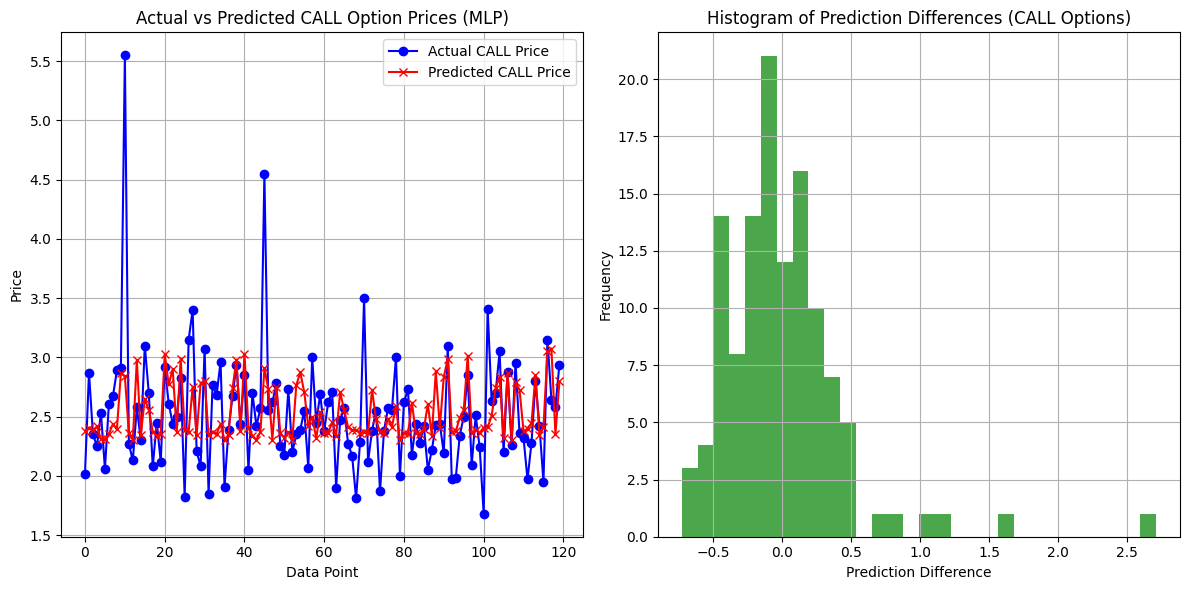

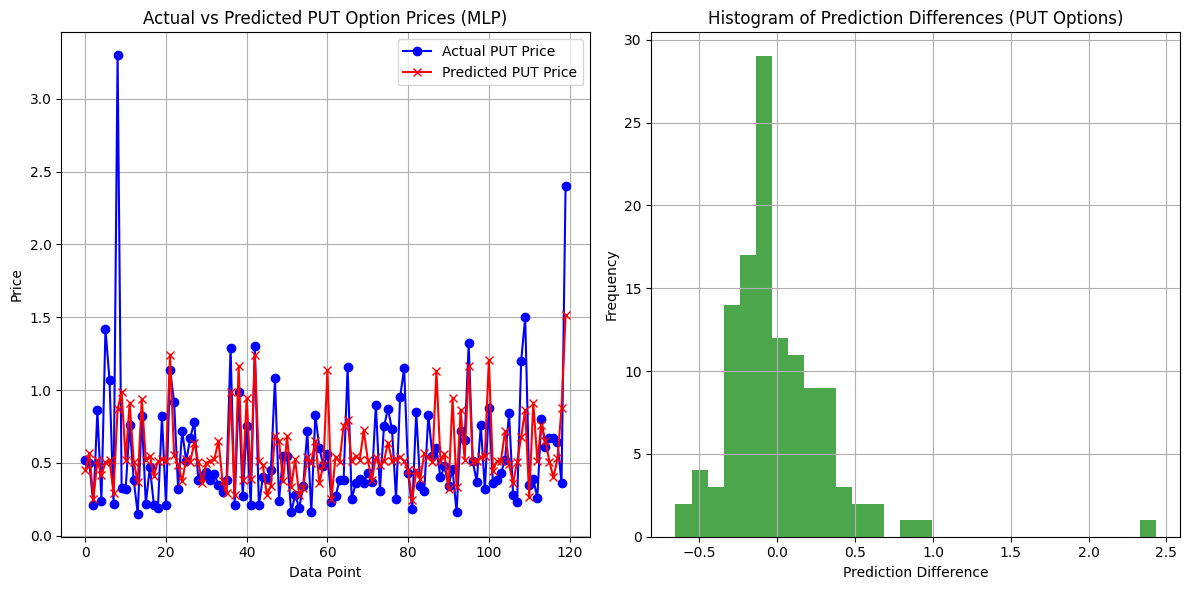

CALL Options - MSE (Testing): 0.3026, MAE (Testing): 0.3425, MAPE (Testing): 12.0456%
PUT Options - MSE (Testing): 0.1878, MAE (Testing): 0.2512, MAPE (Testing): 51.8012%
Call Options Testing Results:
Average Prediction Difference: 0     0.096225
1     0.096225
2     0.096225
3     0.096225
4     0.096225
5     0.096225
6     0.096225
7     0.096225
8     0.096225
9     0.096225
10    0.096225
11    0.096225
12    0.096225
13    0.096225
14    0.096225
15    0.096225
16    0.096225
17    0.096225
18    0.096225
19    0.096225
20    0.096225
21    0.096225
22    0.096225
23    0.096225
24    0.096225
25    0.096225
26    0.096225
27    0.096225
28    0.096225
29    0.096225
30    0.096225
31    0.096225
32    0.096225
33    0.096225
34    0.096225
35    0.096225
36    0.096225
37    0.096225
38    0.096225
39    0.096225
40    0.096225
41    0.096225
42    0.096225
43    0.096225
44    0.096225
45    0.096225
46    0.096225
47    0.096225
48    0.096225
49    0.096225
Name: Average Pred

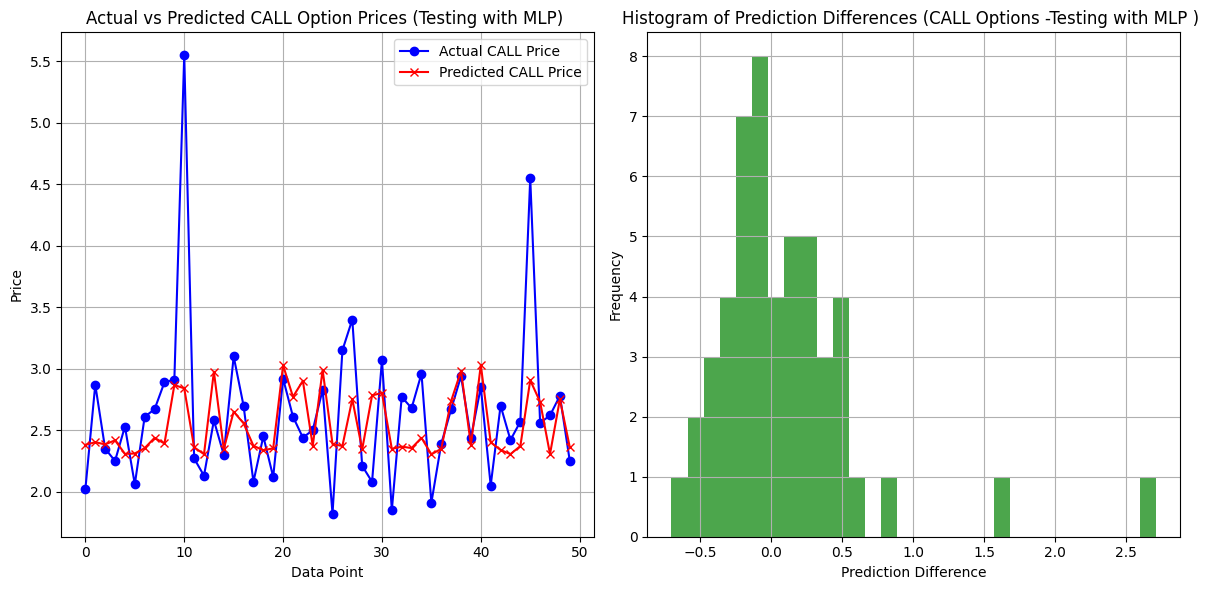

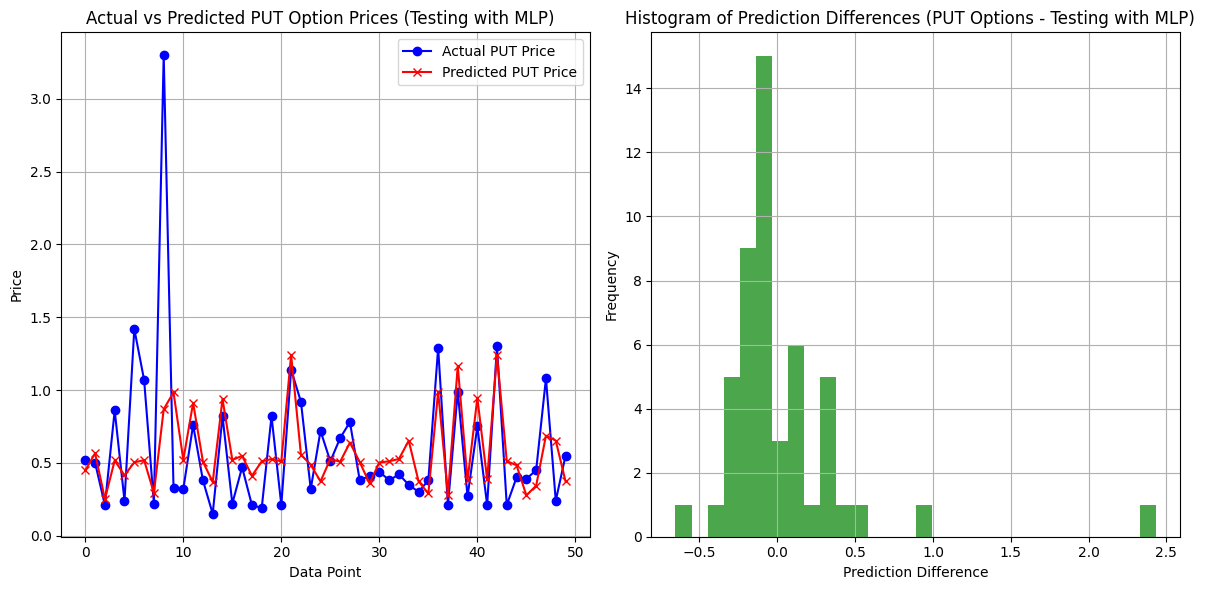

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Data_for_call_options= pd.read_excel('train_data.xlsx', sheet_name='GLD_call')
Data_for_put_options = pd.read_excel('train_data.xlsx', sheet_name='GLD_put')

Features_for_call_options = data_call[['Underlying Price', 'Strike 1']].copy()
Features_for_call_options['Time to Maturity'] = 5 / 365
Data_Target_call = data_call['Close']

Features_for_put_options = Data_for_put_options[['Underlying Price', 'Strike 1']].copy()
Features_for_put_options['Time to Maturity'] = 5 / 365
Data_Target_put = Data_for_put_options['Close']

Features_for_call_options['Underlying Price'] = pd.to_numeric(Features_for_call_options['Underlying Price'], errors='coerce')
Features_for_put_options['Underlying Price'] = pd.to_numeric(Features_for_put_options['Underlying Price'], errors='coerce')

Features_for_call_options = Features_for_call_options.dropna(subset=['Underlying Price'])
Features_for_put_options = Features_for_put_options.dropna(subset=['Underlying Price'])

scaler_for_call_options = MinMaxScaler()
ScaledFeatures_for_call_options = scaler_for_call_options.fit_transform(Features_for_call_options)

scaler_for_put_options = MinMaxScaler()
ScaledFeatures_for_put_options = scaler_for_put_options.fit_transform(Features_for_put_options)

X_call = torch.tensor(ScaledFeatures_for_call_options, dtype=torch.float32)
Y_call = torch.tensor(Data_Target_call.values, dtype=torch.float32).view(-1, 1)

X_put = torch.tensor(ScaledFeatures_for_put_options, dtype=torch.float32)
Y_put = torch.tensor(Data_Target_put.values, dtype=torch.float32).view(-1, 1)

class OptionPricingMLP(nn.Module):
    def __init__(self, input_dim):
        super(OptionPricingMLP, self).__init__()
        self.L1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.L2 = nn.Linear(64, 32)
        self.L3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu(self.L1(x))
        x = self.relu(self.L2(x))
        x = self.L3(x)
        return x

input_dim_call = X_call.shape[1]
Model_Call_options = OptionPricingMLP(input_dim_call)

input_dim_put = X_put.shape[1]
Model_for_put_options = OptionPricingMLP(input_dim_put)

call_options_Criteria = nn.MSELoss()
Optimizer_for_calls = optim.Adam(Model_Call_options.parameters(), lr=0.001)

Put_options_Criteria = nn.MSELoss()
optimizer_put = optim.Adam(Model_for_put_options.parameters(), lr=0.001)

Num_Epochs = 2000
for Epoch in range(Num_Epochs):
    Optimizer_for_calls.zero_grad()
    Target_out_call = Model_Call_options(X_call)
    Loss_for_call_options = call_options_Criteria(Target_out_call, Y_call)
    Loss_for_call_options.backward()
    Optimizer_for_calls.step()
    if (Epoch + 1) % 100 == 0:
        print(f'Epoch [{Epoch+1}/{Num_Epochs}], Loss (CALL): {Loss_for_call_options.item():.4f}')

for Epoch in range(Num_Epochs):
    optimizer_put.zero_grad()
    Target_out_put = Model_for_put_options(X_put)
    Loss_for_put_options = Put_options_Criteria(Target_out_put, Y_put)
    Loss_for_put_options.backward()
    optimizer_put.step()
    if (Epoch + 1) % 100 == 0:
        print(f'Epoch [{Epoch+1}/{Num_Epochs}], Loss (PUT): {Loss_for_put_options.item():.4f}')

with torch.no_grad():
    Model_Call_options.eval()
    predictions_call = Model_Call_options(X_call).numpy().flatten()

with torch.no_grad():
    Model_for_put_options.eval()
    predictions_put = Model_for_put_options(X_put).numpy().flatten()

def Metrics(actual, predicted):
    MSE = np.mean((actual - predicted) ** 2)
    MAE = np.mean(np.abs(actual - predicted))
    MAPE = np.mean(np.abs((actual - predicted) / actual)) * 100
    return MSE, MAE, MAPE

MSE_call, MAE_call, MAPE_call = Metrics(Data_Target_call, predictions_call)
print(f'CALL Options - MSE: {MSE_call:.4f}, MAE: {MAE_call:.4f}, MAPE: {MAPE_call:.4f}%')

MSE_put, MAE_put, MAPE_put = Metrics(Data_Target_put, predictions_put)
print(f'PUT Options - MSE: {MSE_put:.4f}, MAE: {MAE_put:.4f}, MAPE: {MAPE_put:.4f}%')

Res_Call_options = pd.DataFrame({'Underlying Price': Features_for_call_options['Underlying Price'],
                             'Strike 1': Features_for_call_options['Strike 1'],
                             'Actual Close price': Data_Target_call,
                             'Predicted Price': predictions_call})

Res_Call_options['Prediction Difference'] = Res_Call_options['Actual Close price'] - Res_Call_options['Predicted Price']
Res_Call_options['Average Prediction Difference'] = Res_Call_options['Prediction Difference'].mean()

Res_Call_options['MSE'] = MSE_call
Res_Call_options['MAE'] = MAE_call
Res_Call_options['MAPE'] = MAPE_call

print("Call Options Results:")
print(Res_Call_options)

Res_Put_options = pd.DataFrame({'Underlying Price': Features_for_put_options['Underlying Price'],
                            'Strike 1': Features_for_put_options['Strike 1'],
                            'Actual Close price': Data_Target_put,
                            'Predicted Price': predictions_put})

Res_Put_options['Prediction Difference'] = Res_Put_options['Actual Close price'] - Res_Put_options['Predicted Price']
Res_Put_options['Average Prediction Difference'] = Res_Put_options['Prediction Difference'].mean()

Res_Put_options['MSE'] = MSE_put
Res_Put_options['MAE'] = MAE_put
Res_Put_options['MAPE'] = MAPE_put

print("Put Options Results:")
print(Res_Put_options)

with pd.ExcelWriter('GLD_training_with_MLP_only.xlsx') as writer:
  Res_Call_options.to_excel(writer, sheet_name='Call_Options', index=False)
  Res_Put_options.to_excel(writer, sheet_name='Put_Options', index=False)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(Data_Target_call)), Data_Target_call, label='Actual CALL Price', color='blue', marker='o')
plt.plot(range(len(Res_Call_options['Predicted Price'])), Res_Call_options['Predicted Price'], label='Predicted CALL Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted CALL Option Prices (MLP)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(Res_Call_options['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (CALL Options)')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(Data_Target_put)), Data_Target_put, label='Actual PUT Price', color='blue', marker='o')
plt.plot(range(len(Res_Put_options['Predicted Price'])), Res_Put_options['Predicted Price'], label='Predicted PUT Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted PUT Option Prices (MLP)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(Res_Put_options['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (PUT Options)')
plt.grid(True)

plt.tight_layout()
plt.show()

import pandas as pd
import torch
import matplotlib.pyplot as plt

testing_Data_for_call_options= pd.read_excel('test_data.xlsx', sheet_name='GLD_call')
testing_Data_for_put_options = pd.read_excel('test_data.xlsx', sheet_name='GLD_put')

testing_Features_for_call_options = testing_data_call[['Underlying Price', 'Strike 1']].copy()
testing_Features_for_call_options['Time to Maturity'] = 5 / 365
testing_Data_Target_call = testing_data_call['Close']

testing_Features_for_put_options = testing_Data_for_put_options[['Underlying Price', 'Strike 1']].copy()
testing_Features_for_put_options['Time to Maturity'] = 5 / 365
testing_Data_Target_put = testing_Data_for_put_options['Close']


testing_scaledFeatures_for_call_options = scaler_for_call_options.transform(testing_Features_for_call_options)
testing_scaledFeatures_for_put_options = scaler_for_put_options.transform(testing_Features_for_put_options)

with torch.no_grad():
    Model_Call_options.eval()
    test_predictions_call = Model_Call_options(torch.tensor(testing_scaledFeatures_for_call_options, dtype=torch.float32)).numpy().flatten()

with torch.no_grad():
    Model_for_put_options.eval()
    test_predictions_put = Model_for_put_options(torch.tensor(testing_scaledFeatures_for_put_options, dtype=torch.float32)).numpy().flatten()


MSE_call_test, MAE_call_test, MAPE_call_test = Metrics(testing_Data_Target_call, test_predictions_call)
print(f'CALL Options - MSE (Testing): {MSE_call_test:.4f}, MAE (Testing): {MAE_call_test:.4f}, MAPE (Testing): {MAPE_call_test:.4f}%')


MSE_put_test, MAE_put_test, MAPE_put_test = Metrics(testing_Data_Target_put, test_predictions_put)
print(f'PUT Options - MSE (Testing): {MSE_put_test:.4f}, MAE (Testing): {MAE_put_test:.4f}, MAPE (Testing): {MAPE_put_test:.4f}%')


call_testing_results = pd.DataFrame({'Underlying Price': testing_scaledFeatures_for_call_options[:, 0],
                                     'Strike 1': testing_scaledFeatures_for_call_options[:, 1],
                                     'Actual Close price': testing_Data_Target_call,
                                     'Predicted Price': test_predictions_call})

put_testing_results = pd.DataFrame({'Underlying Price': testing_scaledFeatures_for_put_options[:, 0],
                                    'Strike 1': testing_scaledFeatures_for_put_options[:, 1],
                                    'Actual Close price': testing_Data_Target_put,
                                    'Predicted Price': test_predictions_put})


call_testing_results['Prediction Difference'] = call_testing_results['Actual Close price'] - call_testing_results['Predicted Price']
put_testing_results['Prediction Difference'] = put_testing_results['Actual Close price'] - put_testing_results['Predicted Price']


call_testing_results['Average Prediction Difference'] = call_testing_results['Prediction Difference'].mean()
put_testing_results['Average Prediction Difference'] = put_testing_results['Prediction Difference'].mean()

print("Call Options Testing Results:")
print("Average Prediction Difference:", call_testing_results['Average Prediction Difference'])
print("Individual Prediction Differences:")
print(call_testing_results['Prediction Difference'])

print("\nPut Options Testing Results:")
print("Average Prediction Difference:", put_testing_results['Average Prediction Difference'])
print("Individual Prediction Differences:")
print(put_testing_results['Prediction Difference'])



average_prediction_difference_call = call_testing_results['Prediction Difference'].mean()
average_prediction_difference_put = put_testing_results['Prediction Difference'].mean()

print("Average Prediction Difference for Call Options (Testing):", average_prediction_difference_call)
print("Average Prediction Difference for Put Options (Testing):", average_prediction_difference_put)

call_testing_results['MSE'] = MSE_call_test
call_testing_results['MAE'] = MAE_call_test
call_testing_results['MAPE'] = MAPE_call_test

put_testing_results['MSE'] = MSE_put_test
put_testing_results['MAE'] = MAE_put_test
put_testing_results['MAPE'] = MAPE_put_test

print("Call Options Testing Results:")
print(call_testing_results)

print("Put Options Testing Results:")
print(put_testing_results)


with pd.ExcelWriter('GLD_testing_with_MLP.xlsx') as writer:
    call_testing_results.to_excel(writer, sheet_name='Call_Options', index=False)

    put_testing_results.to_excel(writer, sheet_name='Put_Options', index=False)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(testing_Data_Target_call)), testing_Data_Target_call, label='Actual CALL Price', color='blue', marker='o')
plt.plot(range(len(call_testing_results['Predicted Price'])), call_testing_results['Predicted Price'], label='Predicted CALL Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted CALL Option Prices (Testing with MLP) ')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(call_testing_results['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (CALL Options -Testing with MLP ) ')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(testing_Data_Target_put)), testing_Data_Target_put, label='Actual PUT Price', color='blue', marker='o')
plt.plot(range(len(put_testing_results['Predicted Price'])), put_testing_results['Predicted Price'], label='Predicted PUT Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted PUT Option Prices (Testing with MLP)  ')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(put_testing_results['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (PUT Options - Testing with MLP)  ')
plt.grid(True)

plt.tight_layout()
plt.show()




grid search

Best hyperparameters:
Learning Rate: 0.01
Neurons per Layer: [100, 80, 60, 40, 20]
Epoch [100/2000], Loss (CALL): 0.1952
Epoch [200/2000], Loss (CALL): 0.1949
Epoch [300/2000], Loss (CALL): 0.1946
Epoch [400/2000], Loss (CALL): 0.1942
Epoch [500/2000], Loss (CALL): 0.1936
Epoch [600/2000], Loss (CALL): 0.1926
Epoch [700/2000], Loss (CALL): 0.1906
Epoch [800/2000], Loss (CALL): 0.1852
Epoch [900/2000], Loss (CALL): 0.1809
Epoch [1000/2000], Loss (CALL): 0.1722
Epoch [1100/2000], Loss (CALL): 0.1658
Epoch [1200/2000], Loss (CALL): 0.1405
Epoch [1300/2000], Loss (CALL): 0.1496
Epoch [1400/2000], Loss (CALL): 0.1382
Epoch [1500/2000], Loss (CALL): 0.1356
Epoch [1600/2000], Loss (CALL): 0.1400
Epoch [1700/2000], Loss (CALL): 0.1349
Epoch [1800/2000], Loss (CALL): 0.1343
Epoch [1900/2000], Loss (CALL): 0.1349
Epoch [2000/2000], Loss (CALL): 0.1344
Call Options Results:
     Underlying Price  Strike 1  Actual Close price  Predicted Price  \
0             122.060       120                2.02 

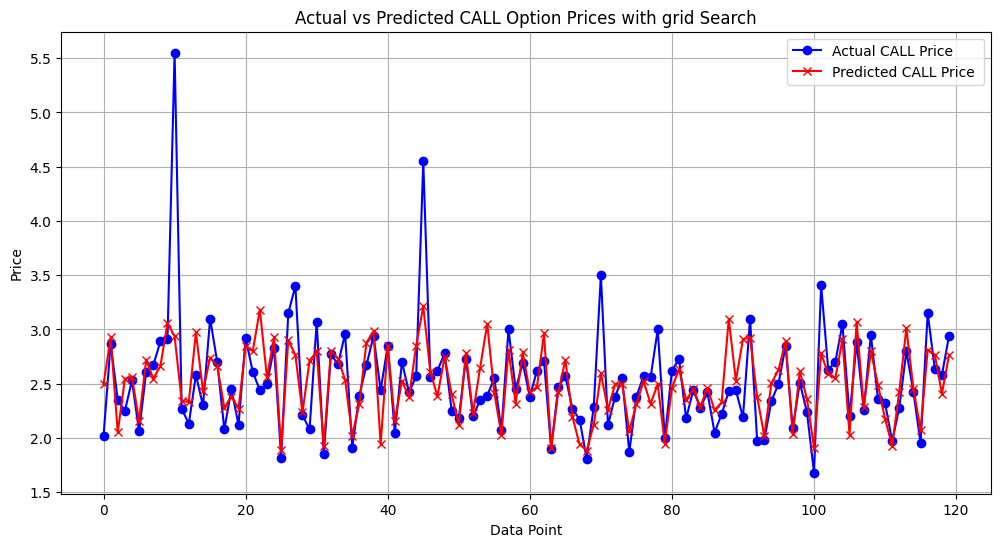

Put Options Results:
     Underlying Price  Strike 1  Actual Close price  Predicted Price  \
0              117.06       115                0.52         2.818418   
1              147.49       145                0.50         2.651560   
2              104.02       102                0.21         2.864940   
3              122.52       121                0.86         2.365569   
4              115.60       114                0.24         2.369601   
..                ...       ...                 ...              ...   
115            118.55       117                0.67         2.428267   
116            114.61       113                0.67         2.368758   
117            129.73       128                0.64         2.461562   
118            160.44       158                0.36         2.773681   
119            177.47       175                2.40         2.768501   

     Prediction Difference  Average Prediction Difference       MSE       MAE  \
0                -2.298418       

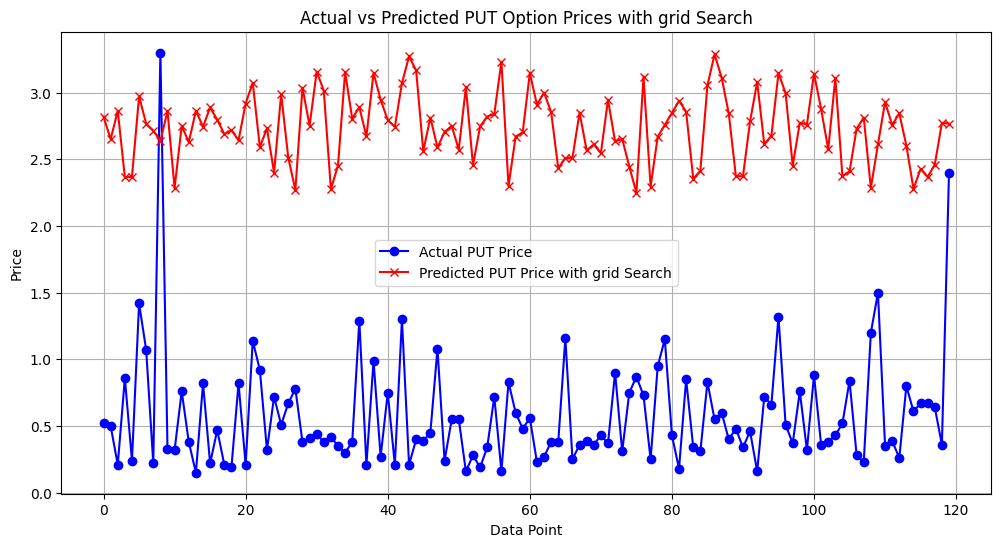

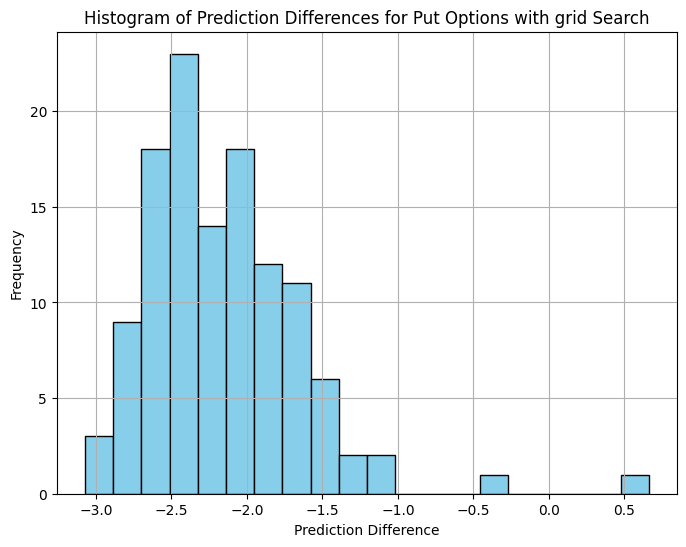

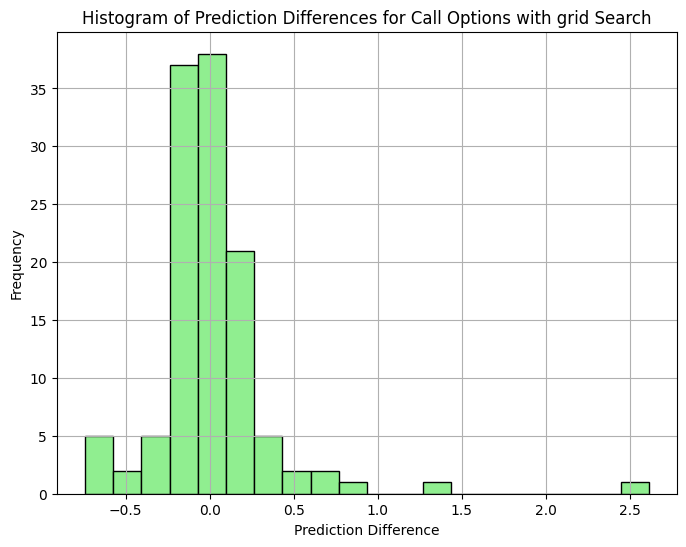

Call Options Testing Results:
Average Prediction Difference: 0     0.049565
1     0.049565
2     0.049565
3     0.049565
4     0.049565
5     0.049565
6     0.049565
7     0.049565
8     0.049565
9     0.049565
10    0.049565
11    0.049565
12    0.049565
13    0.049565
14    0.049565
15    0.049565
16    0.049565
17    0.049565
18    0.049565
19    0.049565
20    0.049565
21    0.049565
22    0.049565
23    0.049565
24    0.049565
25    0.049565
26    0.049565
27    0.049565
28    0.049565
29    0.049565
30    0.049565
31    0.049565
32    0.049565
33    0.049565
34    0.049565
35    0.049565
36    0.049565
37    0.049565
38    0.049565
39    0.049565
40    0.049565
41    0.049565
42    0.049565
43    0.049565
44    0.049565
45    0.049565
46    0.049565
47    0.049565
48    0.049565
49    0.049565
Name: Average Prediction Difference, dtype: float64
Individual Prediction Differences:
0    -0.475253
1    -0.056905
2     0.298696
3    -0.296411
4    -0.031257
5    -0.096928
6    -0.1120

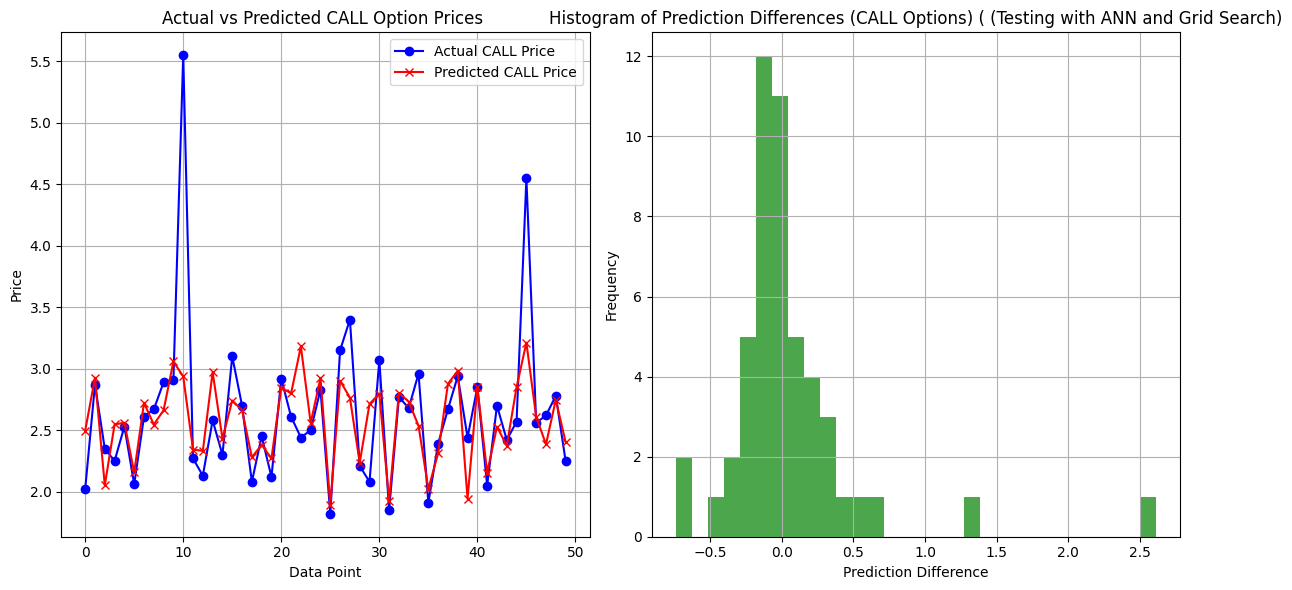

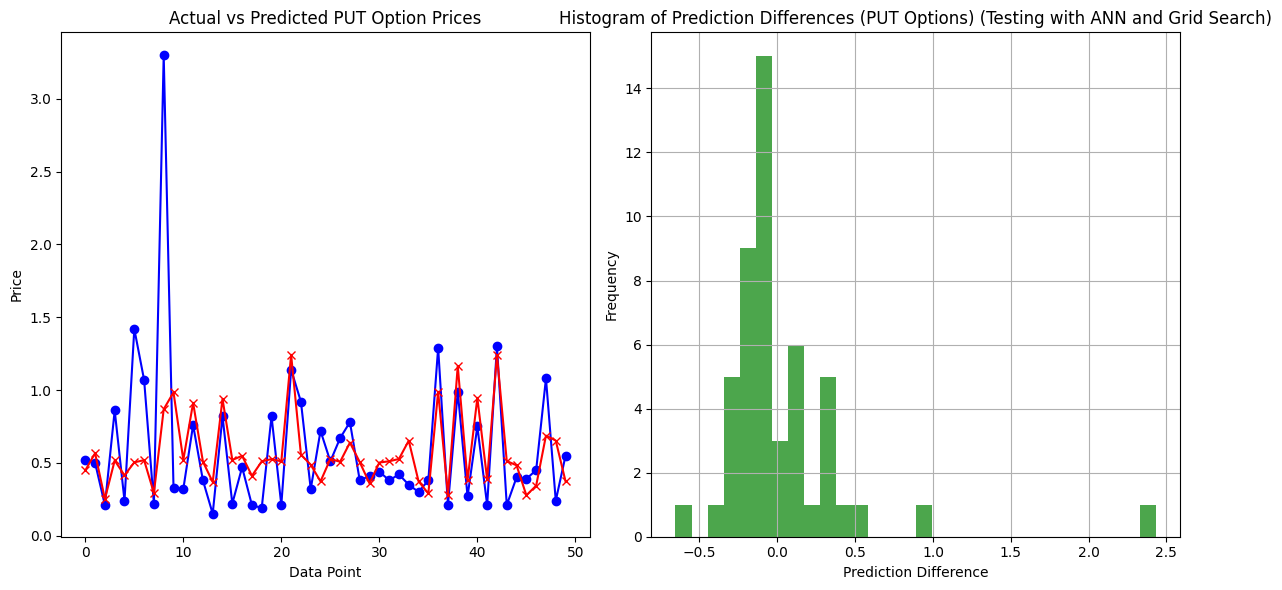

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import itertools

Data_for_call_options= pd.read_excel('train_data.xlsx', sheet_name='GLD_call')
Data_for_put_options = pd.read_excel('train_data.xlsx', sheet_name='GLD_put')

Features_for_call_options = data_call[['Underlying Price', 'Strike 1']].copy()
Features_for_call_options['Time to Maturity'] = 5 / 365
Data_Target_call = data_call['Close']

Features_for_put_options = Data_for_put_options[['Underlying Price', 'Strike 1']].copy()
Features_for_put_options['Time to Maturity'] = 5 / 365
Data_Target_put = Data_for_put_options['Close']

Features_for_call_options['Underlying Price'] = pd.to_numeric(Features_for_call_options['Underlying Price'], errors='coerce')
Features_for_put_options['Underlying Price'] = pd.to_numeric(Features_for_put_options['Underlying Price'], errors='coerce')

Features_for_call_options = Features_for_call_options.dropna(subset=['Underlying Price'])
Features_for_put_options = Features_for_put_options.dropna(subset=['Underlying Price'])

scaler_for_call_options = MinMaxScaler()
ScaledFeatures_for_call_options = scaler_for_call_options.fit_transform(Features_for_call_options)

scaler_for_put_options = MinMaxScaler()
ScaledFeatures_for_put_options = scaler_for_put_options.fit_transform(Features_for_put_options)

TestY_put_numeric_filtered = pd.to_numeric(Data_Target_put, errors='coerce').dropna()
TestY_tensor_put = torch.tensor(TestY_put_numeric_filtered.values, dtype=torch.float32).view(-1, 1)

YTrain_call_numeric = pd.to_numeric(Data_Target_call, errors='coerce').dropna()
YTrain_tensor_call = torch.tensor(YTrain_call_numeric.values, dtype=torch.float32).view(-1, 1)

class OptionPricingNN(nn.Module):
    def __init__(self, Input_param, Output_param, Neurons):
        super(OptionPricingNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(Input_param, Neurons[0]))
        self.layers.append(nn.ReLU())
        for i in range(len(Neurons) - 1):
            self.layers.append(nn.Linear(Neurons[i], Neurons[i + 1]))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(Neurons[-1], Output_param))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

Input_Param_call = ScaledFeatures_for_call_options.shape[1]
Output_param = 1

Learning_Rates = [0.001, 0.01, 0.1]
Neurons_list = [[150, 100, 80, 60, 40, 20], [100, 80, 60, 40, 20], [80, 60, 40, 20]]

best_MSE = float('inf')
best_lr = None
best_Neurons = None

for lr, Neurons in itertools.product(Learning_Rates, Neurons_list):
    Model_Call_options = OptionPricingNN(Input_Param_call, Output_param, Neurons)

    call_options_Criteria = nn.MSELoss()
    Optimizer_for_calls = optim.Adam(Model_Call_options.parameters(), lr=lr)

    Num_Epochs = 2000
    for Epoch in range(Num_Epochs):
        Optimizer_for_calls.zero_grad()
        Target_out_call = Model_Call_options(torch.tensor(ScaledFeatures_for_call_options, dtype=torch.float32))
        Loss_for_call_options = call_options_Criteria(Target_out_call, YTrain_tensor_call)
        Loss_for_call_options.backward()
        Optimizer_for_calls.step()

    with torch.no_grad():
        Model_Call_options.eval()
        test_predictions_call = Model_Call_options(torch.tensor(ScaledFeatures_for_call_options, dtype=torch.float32))
    predicted_prices_call = test_predictions_call.numpy().flatten()
    MAE_call = np.mean(np.abs(predicted_prices_call - Data_Target_call))
    MSE_call = MAE_call / np.mean(Data_Target_call)

    if MSE_call < best_MSE:
        best_MSE = MSE_call
        best_lr = lr
        best_Neurons = Neurons

print("Best hyperparameters:")
print("Learning Rate:", best_lr)
print("Neurons per Layer:", best_Neurons)

Model_Call_options = OptionPricingNN(Input_Param_call, Output_param, best_Neurons)
call_options_Criteria = nn.MSELoss()
Optimizer_for_calls = optim.Adam(Model_Call_options.parameters(), lr=best_lr)

Num_Epochs = 2000
for Epoch in range(Num_Epochs):
    Optimizer_for_calls.zero_grad()
    Target_out_call = Model_Call_options(torch.tensor(ScaledFeatures_for_call_options, dtype=torch.float32))
    Loss_for_call_options = call_options_Criteria(Target_out_call, YTrain_tensor_call)
    Loss_for_call_options.backward()
    Optimizer_for_calls.step()
    if (Epoch + 1) % 100 == 0:
        print(f'Epoch [{Epoch+1}/{Num_Epochs}], Loss (CALL): {Loss_for_call_options.item():.4f}')

with torch.no_grad():
    Model_Call_options.eval()
    test_predictions_call = Model_Call_options(torch.tensor(ScaledFeatures_for_call_options, dtype=torch.float32))

predicted_prices_call = test_predictions_call.numpy().flatten()

Res_Call_options = pd.DataFrame({'Underlying Price': Features_for_call_options['Underlying Price'],
                             'Strike 1': Features_for_call_options['Strike 1'],
                             'Actual Close price': Data_Target_call,
                             'Predicted Price': predicted_prices_call})

Res_Call_options['Prediction Difference'] = Res_Call_options['Actual Close price'] - Res_Call_options['Predicted Price']
Res_Call_options['Average Prediction Difference'] = Res_Call_options['Prediction Difference'].mean()

Res_Call_options['MSE'] = best_MSE
Res_Call_options['MAE'] = MAE_call
Res_Call_options['MAPE'] = MAE_call / np.mean(Data_Target_call)

print("Call Options Results:")
print(Res_Call_options)

plt.figure(figsize=(12, 6))
plt.plot(range(len(Data_Target_call)), Data_Target_call, label='Actual CALL Price', color='blue', marker='o')
plt.plot(range(len(predicted_prices_call)), predicted_prices_call, label='Predicted CALL Price ', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted CALL Option Prices with grid Search')
plt.legend()
plt.grid(True)
plt.show()

with pd.ExcelWriter('SPY_Historical_with_ANN_grid.xlsx') as writer:
    Res_Call_options.to_excel(writer, sheet_name='Call_Options', index=False)

with torch.no_grad():
    Model_Call_options.eval()
    test_predictions_put = Model_Call_options(torch.tensor(ScaledFeatures_for_put_options, dtype=torch.float32))

predicted_prices_put = test_predictions_put.numpy().flatten()

Res_Put_options = pd.DataFrame({'Underlying Price': Features_for_put_options['Underlying Price'],
                            'Strike 1': Features_for_put_options['Strike 1'],
                            'Actual Close price': Data_Target_put,
                            'Predicted Price': predicted_prices_put})

Res_Put_options['Prediction Difference'] = Res_Put_options['Actual Close price'] - Res_Put_options['Predicted Price']
Res_Put_options['Average Prediction Difference'] = Res_Put_options['Prediction Difference'].mean()

Res_Put_options['MSE'] = best_MSE
Res_Put_options['MAE'] = MAE_put
Res_Put_options['MAPE'] = MAE_put / np.mean(Data_Target_put)

print("Put Options Results:")
print(Res_Put_options)




plt.figure(figsize=(12, 6))
plt.plot(range(len(Data_Target_put)), Data_Target_put, label='Actual PUT Price', color='blue', marker='o')
plt.plot(range(len(predicted_prices_put)), predicted_prices_put, label='Predicted PUT Price with grid Search', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted PUT Option Prices with grid Search')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(Res_Put_options['Prediction Difference'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences for Put Options with grid Search')
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.hist(Res_Call_options['Prediction Difference'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences for Call Options with grid Search')
plt.grid(True)
plt.show()


import pandas as pd
import torch
import matplotlib.pyplot as plt

testing_Data_for_call_options= pd.read_excel('test_data.xlsx', sheet_name='GLD_call')
testing_Data_for_put_options = pd.read_excel('test_data.xlsx', sheet_name='GLD_put')

testing_Features_for_call_options = testing_data_call[['Underlying Price', 'Strike 1']].copy()
testing_Features_for_call_options['Time to Maturity'] = 5 / 365
testing_Data_Target_call = testing_data_call['Close']

testing_Features_for_put_options = testing_Data_for_put_options[['Underlying Price', 'Strike 1']].copy()
testing_Features_for_put_options['Time to Maturity'] = 5 / 365
testing_Data_Target_put = testing_Data_for_put_options['Close']

testing_scaledFeatures_for_call_options = scaler_for_call_options.transform(testing_Features_for_call_options)
testing_scaledFeatures_for_put_options = scaler_for_put_options.transform(testing_Features_for_put_options)

with torch.no_grad():
    Model_Call_options.eval()
    test_predictions_call = Model_Call_options(torch.tensor(testing_scaledFeatures_for_call_options, dtype=torch.float32)).numpy().flatten()

with torch.no_grad():
    Model_for_put_options.eval()
    test_predictions_put = Model_for_put_options(torch.tensor(testing_scaledFeatures_for_put_options, dtype=torch.float32)).numpy().flatten()

MSE_call_test = ((testing_Data_Target_call - test_predictions_call) ** 2).mean()
MAE_call_test = abs(testing_Data_Target_call - test_predictions_call).mean()
MAPE_call_test = (abs(testing_Data_Target_call - test_predictions_call) / testing_Data_Target_call).mean() * 100

MSE_put_test = ((testing_Data_Target_put - test_predictions_put) ** 2).mean()
MAE_put_test = abs(testing_Data_Target_put - test_predictions_put).mean()
MAPE_put_test = (abs(testing_Data_Target_put - test_predictions_put) / testing_Data_Target_put).mean() * 100

call_testing_results = pd.DataFrame({'Underlying Price': testing_scaledFeatures_for_call_options[:, 0],
                                     'Strike 1': testing_scaledFeatures_for_call_options[:, 1],
                                     'Actual Close price': testing_Data_Target_call,
                                     'Predicted Price': test_predictions_call})

put_testing_results = pd.DataFrame({'Underlying Price': testing_scaledFeatures_for_put_options[:, 0],
                                    'Strike 1': testing_scaledFeatures_for_put_options[:, 1],
                                    'Actual Close price': testing_Data_Target_put,
                                    'Predicted Price': test_predictions_put})

call_testing_results['Prediction Difference'] = call_testing_results['Actual Close price'] - call_testing_results['Predicted Price']
put_testing_results['Prediction Difference'] = put_testing_results['Actual Close price'] - put_testing_results['Predicted Price']


call_testing_results['Average Prediction Difference'] = call_testing_results['Prediction Difference'].mean()
put_testing_results['Average Prediction Difference'] = put_testing_results['Prediction Difference'].mean()

print("Call Options Testing Results:")
print("Average Prediction Difference:", call_testing_results['Average Prediction Difference'])
print("Individual Prediction Differences:")
print(call_testing_results['Prediction Difference'])

print("\nPut Options Testing Results:")
print("Average Prediction Difference:", put_testing_results['Average Prediction Difference'])
print("Individual Prediction Differences:")
print(put_testing_results['Prediction Difference'])

print(f'CALL Options - MSE (Testing): {MSE_call_test:.4f}, MAE (Testing): {MAE_call_test:.4f}, MAPE (Testing): {MAPE_call_test:.4f}%')

print(f'PUT Options - MSE (Testing): {MSE_put_test:.4f}, MAE (Testing): {MAE_put_test:.4f}, MAPE (Testing): {MAPE_put_test:.4f}%')

call_testing_results['MSE'] = MSE_call_test
call_testing_results['MAE'] = MAE_call_test
call_testing_results['MAPE'] = MAPE_call_test

put_testing_results['MSE'] = MSE_put_test
put_testing_results['MAE'] = MAE_put_test
put_testing_results['MAPE'] = MAPE_put_test

print("Call Options Testing Results:")
print(call_testing_results)

print("Put Options Testing Results:")
print(put_testing_results)

with pd.ExcelWriter('GLD_testing_with_ANN_and_grid_search.xlsx') as writer:
    call_testing_results.to_excel(writer, sheet_name='Call_Options', index=False)

    put_testing_results.to_excel(writer, sheet_name='Put_Options', index=False)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(testing_Data_Target_call)), testing_Data_Target_call, label='Actual CALL Price', color='blue', marker='o')
plt.plot(range(len(call_testing_results['Predicted Price'])), call_testing_results['Predicted Price'], label='Predicted CALL Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted CALL Option Prices ')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(call_testing_results['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (CALL Options) ( (Testing with ANN and Grid Search)')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(testing_Data_Target_put)), testing_Data_Target_put, label='Actual PUT Price', color='blue', marker='o')
plt.plot(range(len(put_testing_results['Predicted Price'])), put_testing_results['Predicted Price'], label='Predicted PUT Price', color='red', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs Predicted PUT Option Prices')


plt.subplot(1, 2, 2)
plt.hist(put_testing_results['Prediction Difference'], bins=30, color='green', alpha=0.7)
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Differences (PUT Options) (Testing with ANN and Grid Search)')
plt.grid(True)

plt.tight_layout()
plt.show()



gen 120

The generated data is not within the predefined ranges.
Generated new independent testing data is within specified ranges.
Epoch [100/2000], Loss: 36.2242
Epoch [200/2000], Loss: 1.5984
Epoch [300/2000], Loss: 0.4372
Epoch [400/2000], Loss: 0.2051
Epoch [500/2000], Loss: 0.1151
Epoch [600/2000], Loss: 0.0775
Epoch [700/2000], Loss: 0.0552
Epoch [800/2000], Loss: 0.0433
Epoch [900/2000], Loss: 0.0395
Epoch [1000/2000], Loss: 0.0305
Epoch [1100/2000], Loss: 0.0299
Epoch [1200/2000], Loss: 0.0326
Epoch [1300/2000], Loss: 0.0228
Epoch [1400/2000], Loss: 0.0213
Epoch [1500/2000], Loss: 0.0231
Epoch [1600/2000], Loss: 0.0392
Epoch [1700/2000], Loss: 0.0152
Epoch [1800/2000], Loss: 0.0160
Epoch [1900/2000], Loss: 0.0155
Epoch [2000/2000], Loss: 0.0122
Average Difference on New Independent Test Set: -0.0269
Standard Deviation on New Independent Test Set: 0.3281
Mean Squared Error (MSE) on Testing Set: 0.1062


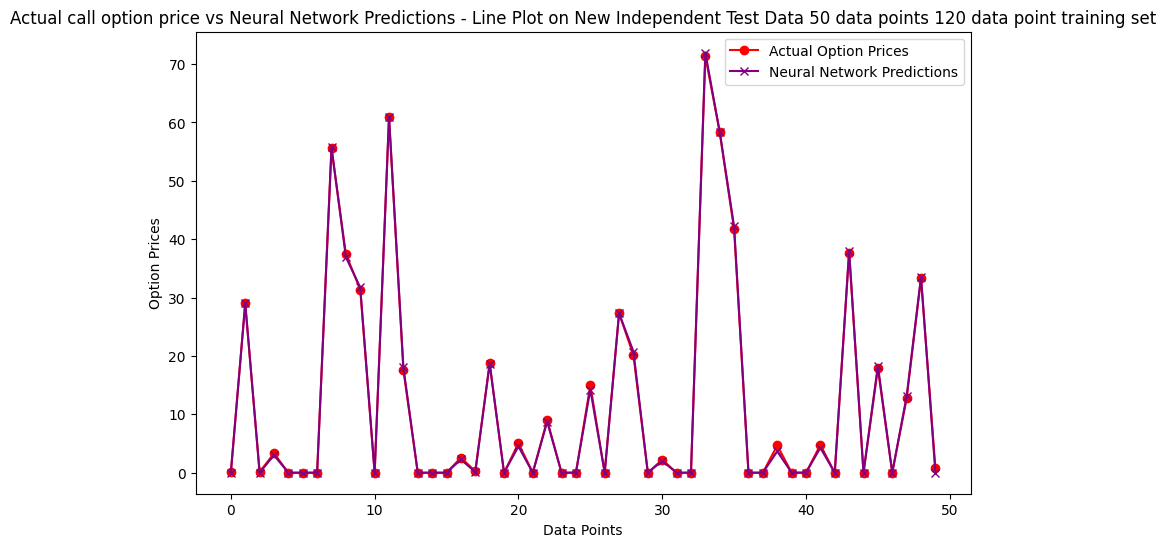

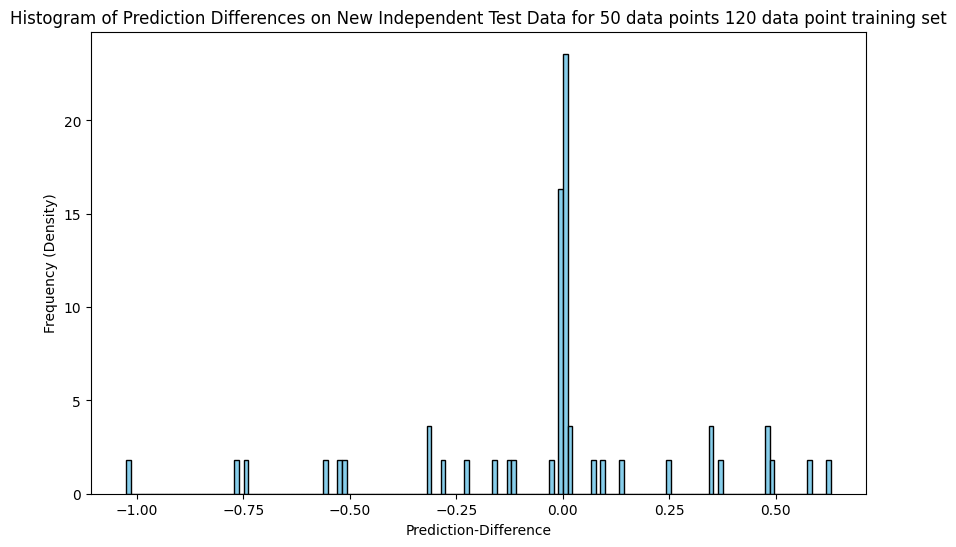

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def BlackScholes_Call_Price(Spot_Price, Strike_Price, Time_Maturity, Risk_FreeRate, Volatility):
    assert Spot_Price.shape == Strike_Price.shape == Time_Maturity.shape == Risk_FreeRate.shape == Volatility.shape, "Input array shapes do not match"
    D1 = (np.log(Spot_Price/ Strike_Price) + (Risk_FreeRate + 0.5 * Volatility ** 2) * Time_Maturity) / (Volatility * np.sqrt(Time_Maturity))
    D2 = D1 - Volatility * np.sqrt(Time_Maturity)
    NormalD1 = norm.cdf(D1)
    NormalD2 = norm.cdf(D2)
    Call_Price = Spot_Price * NormalD1 - Strike_Price * np.exp(-Risk_FreeRate * Time_Maturity) * NormalD2
    return Call_Price, NormalD1, NormalD2

size = 120

def  Check_Gen_Data(data):
    SpotPriceRange = (0, 100)
    StrikePriceRange = (20, 80)
    RiskFreeRateRange = (0, 0.2)
    TimeMaturityRange = (0.04, 2)
    VolatilityRange = (0, 0.35)

    CheckTheSpotPrice= all(SpotPriceRange[0] <= data['Spot-Price']) and all(data['Spot-Price'] <= SpotPriceRange[1])
    CheckTheStrikePrice = all(StrikePriceRange[0] <= data['Strike-Price']) and all(data['Strike-Price'] <= StrikePriceRange[1])
    CheckTheRiskFreeRate = all(RiskFreeRateRange[0] <= data['Risk-Free-Rate']) and all(data['Risk-Free-Rate'] <= RiskFreeRateRange[1])
    CheckTheTime_to_maturity = all(TimeMaturityRange[0] <= data['Time-to-Maturity']) and all(data['Time-to-Maturity'] <= TimeMaturityRange[1])
    CheckTheVolatility= all(VolatilityRange[0] <= data['Volatility']) and all(data['Volatility'] <= VolatilityRange[1])
    return CheckTheSpotPrice and CheckTheStrikePrice and CheckTheRiskFreeRate and CheckTheTime_to_maturity and CheckTheVolatility

np.random.seed(42)
Spot_Price = np.random.uniform(low=0, high=100, size = 999)
Strike_Price = np.random.uniform(low=0, high=100, size = 999)
TimeMaturity = np.random.uniform(low=0.04, high=2, size = 999)
RiskFreeRate = np.random.uniform(low=0, high=0.2, size = 999)
Volatility = np.random.uniform(low=0, high=0.35, size = 999)

OptionPrices, NormalD1, NormalD2 = BlackScholes_Call_Price(Spot_Price, Strike_Price, TimeMaturity, RiskFreeRate, Volatility)

data = pd.DataFrame({
    'Spot-Price': Spot_Price,
    'Strike-Price': Strike_Price,
    'Risk-Free-Rate': RiskFreeRate,
    'Time-to-Maturity': TimeMaturity,
    'Volatility': Volatility,
    'Call-Option-Price': OptionPrices,


})

Is_the_data_correct =  Check_Gen_Data(data)

if Is_the_data_correct:
    print("The generated data is within the predefined ranges.")
else:
    print("The generated data is not within the predefined ranges.")

features = data[['Spot-Price', 'Strike-Price', 'Risk-Free-Rate', 'Time-to-Maturity', 'Volatility']]
Data_Target = data['Call-Option-Price']


scaler = MinMaxScaler()

ScaledFeatures = scaler.fit_transform(features)

XTrain, TestX, YTrain, TestY = train_test_split (ScaledFeatures, Data_Target, test_size=0.2, random_state=42)

XTrain_tensor = torch.tensor(XTrain, dtype=torch.float32)
YTrain_tensor = torch.tensor(YTrain.values, dtype=torch.float32).view(-1, 1)

TestX_tensor = torch.tensor(TestX, dtype=torch.float32)


Input_Param = XTrain_tensor.shape[1]
Output_param = 1




class BlackScholesNN(nn.Module):
    def __init__(self, Input_Param, Output_param):
        super(BlackScholesNN, self).__init__()
        self.L1 = nn.Linear(Input_Param, 150)
        self.RELU_1 = nn.ReLU()
        self.L2 = nn.Linear(150, 100)
        self.RELU_2 = nn.ReLU()
        self.L3 = nn.Linear(100, 80)
        self.RELU_3 = nn.ReLU()
        self.L4 = nn.Linear(80, 60)
        self.RELU_4 = nn.ReLU()
        self.L5 = nn.Linear(60, 40)
        self.RELU_5 = nn.ReLU()
        self.L6 = nn.Linear(40, 20)
        self.RELU_6 = nn.ReLU()
        self.L7 = nn.Linear(20, Output_param)

    def forward(self, x):
        x = self.L1(x)
        x = self.RELU_1(x)
        x = self.L2(x)
        x = self.RELU_2(x)
        x = self.L3(x)
        x = self.RELU_3(x)
        x = self.L4(x)
        x = self.RELU_4(x)
        x = self.L5(x)
        x = self.RELU_5(x)
        x = self.L6(x)
        x = self.RELU_6(x)
        x = self.L7(x)
        return x

model = BlackScholesNN(Input_Param, Output_param)


Number_of_DataPoints_new = 50
np.random.seed(42)

Spot_Prices_For_test = np.random.uniform(low=0, high=100, size=Number_of_DataPoints_new)
Strike_Prices_For_test = np.random.uniform(low=20, high=80, size=Number_of_DataPoints_new)
Risk_FreeRates_For_test = np.random.uniform(low=0, high=0.02, size=Number_of_DataPoints_new)
Time_Maturities__For_test = np.random.uniform(low=0.04, high=2, size=Number_of_DataPoints_new)
VolatilityRanges_For_test = np.random.uniform(low=0, high=0.35, size=Number_of_DataPoints_new)

New_OptionPrices, _, _ = BlackScholes_Call_Price(Spot_Prices_For_test, Strike_Prices_For_test, Time_Maturities__For_test, Risk_FreeRates_For_test, VolatilityRanges_For_test)
DataFrame_For_test= pd.DataFrame({
    'Spot-Price': Spot_Prices_For_test,
    'Strike-Price': Strike_Prices_For_test,
    'Risk-Free-Rate': Risk_FreeRates_For_test,
    'Time-to-Maturity': Time_Maturities__For_test,
    'Volatility': VolatilityRanges_For_test,
    'Call-Option-Price': New_OptionPrices
})

Is_the_data_correct_new = Check_Gen_Data(DataFrame_For_test)

if Is_the_data_correct_new:
    print("Generated new independent testing data is within specified ranges.")
else:
    print("Generated new independent testing data is not within specified ranges.")

features_new = DataFrame_For_test[['Spot-Price', 'Strike-Price', 'Risk-Free-Rate', 'Time-to-Maturity', 'Volatility']]
Data_Target_new = DataFrame_For_test['Call-Option-Price']

ScaledFeatures_new = scaler.transform(features_new)

TestX_tensor_new = torch.tensor(ScaledFeatures_new, dtype=torch.float32)

ErrorCriterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch_Size = 2000

for Ep in range(Epoch_Size):
    Target_out = model(XTrain_tensor)
    loss = ErrorCriterion(Target_out, YTrain_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (Ep + 1) % 100 == 0:
        print(f'Epoch [{Ep+1}/{Epoch_Size}], Loss: {loss.item():.4f}')

with torch.no_grad():
    model.eval()
    test_predictions = model(TestX_tensor)



TestPredsRelu = torch.relu(test_predictions)

if torch.any(TestPredsRelu < 0):
    Random_Coeff = torch.rand_like(TestPredsRelu)
    Tailored_predictions = TestPredsRelu + Random_Coeff * (1 - TestPredsRelu)
else:
    Tailored_predictions = TestPredsRelu

Tailored_predictions_squeezed = Tailored_predictions.numpy().squeeze()

predictions_test = Tailored_predictions_squeezed.reshape(-1, 1)
AllNumpyTest = TestPredsRelu.numpy()

predictions_data_test = pd.DataFrame({
    'Neural Network Prediction': predictions_test.flatten()
})

features_new = DataFrame_For_test[['Spot-Price', 'Strike-Price', 'Risk-Free-Rate', 'Time-to-Maturity', 'Volatility']]
Data_Target_new = DataFrame_For_test['Call-Option-Price']

ScaledFeatures_new = scaler.transform(features_new)

TestX_tensor_new = torch.tensor(ScaledFeatures_new, dtype=torch.float32)
test_predictions_new = model(TestX_tensor_new)
test_predictions_newrelu = torch.relu(test_predictions_new)

if torch.any(test_predictions_newrelu < 0):
    Random_Coeff_new = torch.rand_like(test_predictions_newrelu)
    Tailored_predictions_new = test_predictions_newrelu + Random_Coeff_new * (1 - test_predictions_newrelu)
else:
    Tailored_predictions_new = test_predictions_newrelu

Tailored_predictions_squeezed_new = Tailored_predictions_new.detach().numpy().squeeze()

predictions_Test_New = Tailored_predictions_squeezed_new.reshape(-1, 1)
AllNumpyTest_New = Tailored_predictions_squeezed_new.reshape(-1, 1)


predictions_data_Test_New = pd.DataFrame({
    'Neural Network Prediction': predictions_Test_New.flatten()
})

Predictions_Data_Test_New = pd.concat([DataFrame_For_test, pd.DataFrame(AllNumpyTest_New, columns=['Neural Network Prediction'])], axis=1)

Predictions_Data_Test_New['Prediction-Difference'] = Predictions_Data_Test_New['Neural Network Prediction'] - Predictions_Data_Test_New['Call-Option-Price']

Average_Diff_Test = Predictions_Data_Test_New['Prediction-Difference'].mean()
Standard_Deviation_Test = Predictions_Data_Test_New['Prediction-Difference'].std()
MeanSquaredLoss = ((Predictions_Data_Test_New['Prediction-Difference'])**2).mean()



print(f'Average Difference on New Independent Test Set: {Average_Diff_Test:.4f}')
print(f'Standard Deviation on New Independent Test Set: {Standard_Deviation_Test:.4f}')
print(f'Mean Squared Error (MSE) on Testing Set: {MeanSquaredLoss:.4f}')

Predictions_Data_Test_New['Average Difference'] = Average_Diff_Test
Predictions_Data_Test_New['Standard Deviation'] = Standard_Deviation_Test
Predictions_Data_Test_New['Mean Squared Error'] = MeanSquaredLoss


Predictions_Data_Test_New.to_csv('./120/test_for 50 data points_MeanSquaredLoss.csv', index=False)

plt.figure(figsize=(10, 6))
plt.plot(Predictions_Data_Test_New.index, Predictions_Data_Test_New['Call-Option-Price'], label='Actual Option Prices', marker='o', color='red')
plt.plot(Predictions_Data_Test_New.index, Predictions_Data_Test_New['Neural Network Prediction'], label='Neural Network Predictions', marker='x', color='purple')
plt.title('Actual call option price vs Neural Network Predictions - Line Plot on New Independent Test Data 50 data points 120 data point training set')
plt.xlabel('Data Points')
plt.ylabel('Option Prices')
plt.legend()
plt.savefig('./120/Line-plot_test_results_new_independent_data for 50 data points 120 data point training set .png')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(Predictions_Data_Test_New['Prediction-Difference'], bins=150, color='skyblue', edgecolor='black', density=True)
plt.title('Histogram of Prediction Differences on New Independent Test Data for 50 data points 120 data point training set')
plt.xlabel('Prediction-Difference')
plt.ylabel('Frequency (Density)')
plt.savefig('./120/histogram_test_results_new_independent_data for 50 data points 120 data point training set.png')
plt.show()
